In [1]:
import os
import astropy
import requests
import pandas as pd
import numpy as np
import lightkurve as lk 
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
import emcee
import sys
import csv
from astropy.timeseries import LombScargle
from os.path import basename, exists

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/utils/')
import filters # Suzanne's functions
import norm

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/ETV')
import etv_functions # Nora's functions 

from importlib import reload

%matplotlib inline

In [2]:
from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_base = './etv_out'  # for ETV
lk_download_dir = 'C:/dev/_juypter/PH_TESS_LightCurveViewer/data'  

# A command from shell that can be run to notify users, e.g., fitting is finished. Use "echo" if you do not have one
NOTIFY_CMD = "win-notify.bat"

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_second = 86400

## Looking for ETVs in TIC 410354930


In [3]:
# define the plotting parameters

figsize = (8,4)

In [4]:
# import the data

# choose a TIC ID to analyze
ticid = 410354930

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_path = f"{outfile_base}/tic{ticid}_etv_primary.csv"
outfile_path_s = f"{outfile_base}/tic{ticid}_etv_secondary.csv"


# import data using Lightkurve
# sr = lk.search_lightcurve('TIC {}'.format(ticid), author = 'SPOC')  
if not "../.." in sys.path:
    sys.path.append("../..")
import lightkurve_ext as lke  # at ../../
import astropy.units as u


sr = lk.search_lightcurve('TIC {}'.format(ticid))  # get long cadence data too
sr = lke.filter_by_priority(sr, author_priority=['SPOC', 'TESS-SPOC', 'QLP'], exptime_priority=['short', 'long', 'fast'])
# sr = sr[sr.exptime != 1800 *u.s]  # exclude 30min cadence data for now (TESS-SPOC, sectors 18, 19, 23 )
# sr = sr[np.isin(sr.author, ['SPOC', 'TESS-SPOC'])]  # exclude QLP to ensure for uniformity in the data
sr = lke._sort_chronologically(sr)  # workaround lightkurve v2.4.2+ change in sort order
with astropy.conf.set_temp("max_lines", -1):
    display(sr)
lcc_tess = sr.download_all()
lc_tess = lcc_tess.stitch()
# lc_tess = lc_tess.truncate(None, 1450)  # use data from sectors 2 - 3 for now


search_result = lc_tess

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

SearchResult containing 7 data products.

 #     mission     year   author  exptime target_name distance proposal_id
                                     s                 arcsec             
--- -------------- ---- --------- ------- ----------- -------- -----------
  0 TESS Sector 01 2018      SPOC     120   410354930      0.0     G011154
  1 TESS Sector 12 2019 TESS-SPOC    1800   410354930      0.0         N/A
  2 TESS Sector 27 2020 TESS-SPOC     600   410354930      0.0         N/A
  3 TESS Sector 39 2021 TESS-SPOC     600   410354930      0.0         N/A
  4 TESS Sector 65 2023      SPOC     120   410354930      0.0      G05003
  5 TESS Sector 66 2023      SPOC     120   410354930      0.0      G05003
  6 TESS Sector 67 2023      SPOC     120   410354930      0.0      G05003

84132

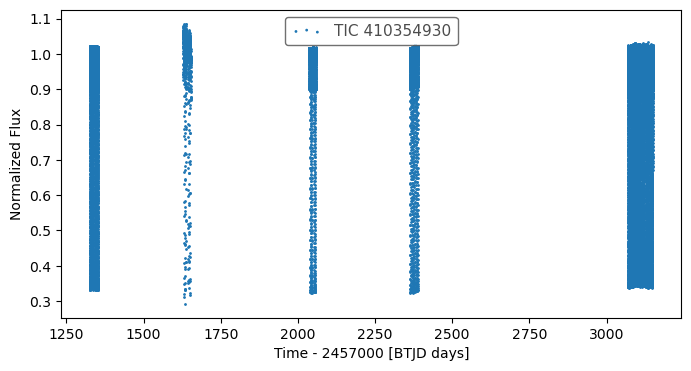

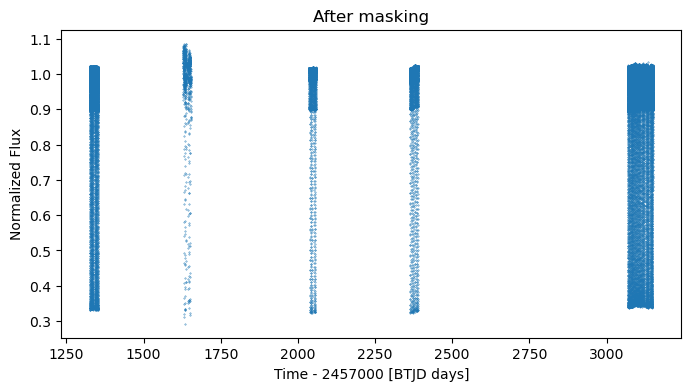

In [5]:
%matplotlib inline
# %matplotlib widget

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

# mask out data you don't like...

fig, ax = plt.subplots(figsize=figsize)
search_result.scatter(ax = ax)

mask = time < 0  #( time > 54950) & (time < 54963)  #  truncate weird spikes at the beginning of Kepler data  
# mask = flux < 0.85    # remove occasional outliers
# mask = (
#     ( flux < 0.95 ) | # remove occasional lone outliers
#     # cadences where scattered light effect is prevalent
#     ( (time > 2718)   & (time < 2744) ) 
# )

time = time[~mask]
flux = flux[~mask]
fluxerr = fluxerr[~mask]

# make sure that therte are no nans!

finite_mask = np.isfinite(time) * np.isfinite(flux) * np.isfinite(fluxerr)

# make a dictionary of the data 

data = pd.DataFrame({'time': time[finite_mask], 'flux': flux[finite_mask], 'err': fluxerr[finite_mask]})

ax2 = plt.figure(figsize=figsize).gca()
ax2.scatter(data.time, data.flux, s=0.1);
ax2.set_ylabel(ax.get_ylabel())
ax2.set_xlabel(ax.get_xlabel())
ax2.set_title("After masking");

In [6]:
do_bls = False

if do_bls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg_runner as lke_pg_runner  # at ../../

    bls_result = lke_pg_runner.run_bls(
        search_result.remove_nans(),
        pg_kwargs=dict(
            minimum_period=1, maximum_period=20,
            frequency_factor=1,            
            duration=[3.4957 / 24 * f for f in [0.975, 1, 1.025, 1.05, 1.1, 1.15,]],  # based on observed primary eclipse duration for better fit
        ),
    )
    !$NOTIFY_CMD  "BLS Done"

In [7]:
do_ls = False

if do_ls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg as lke_pg  # at ../../

    lc = lk.LightCurve(time=Time(time, format="btjd"), flux=flux, flux_err=fluxerr)
    lc.meta["LABEL"] = f"TIC {ticid}"
    pg = lc.to_periodogram(method="lombscargle",
                           # maximum_period=10,
                           # minimum_period=0.4,                    
                           # ls_method="fastchi2", nterms=2,
                           # oversample_factor=50,  # default: 5
                          )
         
    pg.show_properties();
    print(pg.period_at_max_power);
    
    ax = lke_pg.plot_pg_n_mark_max(pg, max_period_factor=10);
    
    ax = pg.plot(view="frequency");  # frequency view
    ax.set_xlim(pg.frequency_at_max_power.value / 100 , pg.frequency_at_max_power.value * 10);

    ax = pg.plot(view="frequency", unit=u.microhertz, scale="log");  

    axs, lcs = lke_pg.plot_lc_with_model(
        lc,
        pg, 
        plot_lc=False, plot_model=False, plot_folded_model=True,
        also_return_lcs=True);


In [ ]:
# Visaully compare different candidate period

# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418132651611877).truncate(-0.1, 0.1).scatter(label="BLS period, frequency_factor=10");  # HWHM 0.001571020094789155
# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418147).truncate(-0.1, 0.1).scatter(label="s0001-s0009:TCE1");

### Define epoch, period, duration

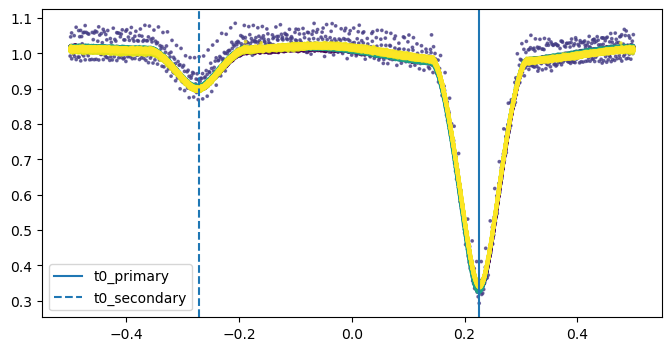

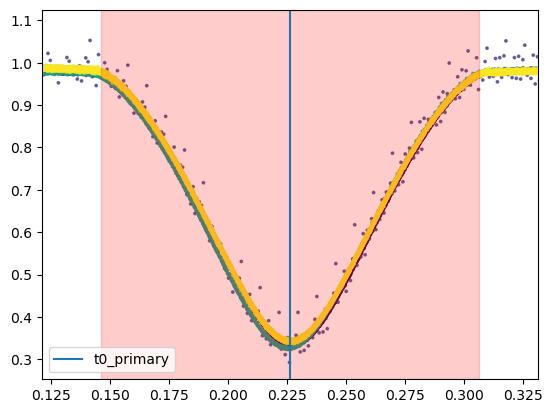

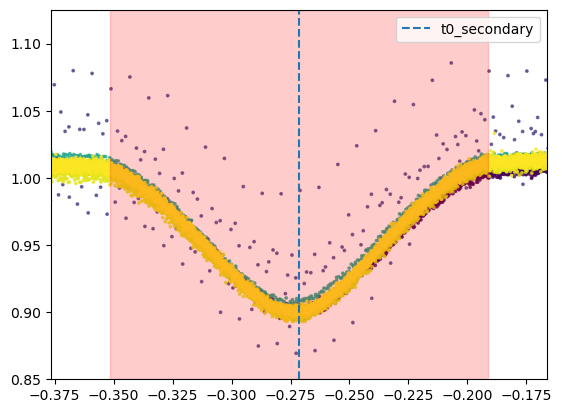

In [13]:
%matplotlib inline
# %matplotlib widget

from astropy.time import Time

# define the orbital period and the t0 

# epoch=1326.38, duration_hr=4.5, period=2.59951, label="s0001s0069tce1", transit_depth_percent=65.4656,
# epoch=1326.36, duration_hr=11.5651, period=1.30072, label="s0001s0069tce2", transit_depth_percent=12.5445,
# VSX: 2.59959 
# MCMC on df_primary (with ingress/egress): 2.5995257309735464, err=1e-8,  t0=1326.3732112756243,
# MCMC on df_primary (no ingress/egress)  : 2.5995255180977836, err=1e-8,  t0=1326.3733013599162,

# FILL-IN THE eclipse epoch / period, 
# period = 2.59959 
# period = 2.59951  # TCE1
# period = 2.5995257309735464  # MCMC with ingress/egress  (forgot to round it)
period = 2.5995255  # MCMC no ingress/egress

# t0_primary = 1326.38 - 0.005  # TCE1 + manual offset
t0_primary = 1326.373  # MCMC
t0_secondary = t0_primary + 1.306

duration_hr_primary = 10.0
duration_hr_secondary = 10.0

# convert epoch from BTJD to commonly mjd used here
# t0_primary = Time(t0_primary, format="btjd").to_value("mjd")
# t0_secondary = Time(t0_secondary, format="btjd").to_value("mjd")

# Move t0 to the first dip in the data (some of the subsequent codes, espically fit_each_eclipse(), assumes that)
t0_primary = t0_primary - int((t0_primary - data['time'][0]) / period) * period
if t0_secondary is not None:
    t0_secondary = t0_secondary - int((t0_secondary - data['time'][0]) / period) * period

t0_for_plotting = 0  # keep 0 for plotting purposes
if t0_secondary is not None:
    t0_for_plotting = t0_primary - np.abs(t0_primary - t0_secondary) * 0.45  # use a custom one so that the eclipses are not near the edge (-0.5 or +0.5)

phase = etv_functions.phase_data(data['time'], t0_for_plotting, period)

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])

# add the phase to the dataframe
data['phase'] = phase

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
t1_p, t4_p = etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.5 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.5 * duration_hr_primary / 24/ period 
plt.xlim(t1_p - 0.025, t4_p + 0.025);
plt.axvspan(t1_p, t4_p, color="red", alpha=0.2);plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

if t0_secondary is not None:
    plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
    t1_s, t4_s = etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.5 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.5 * duration_hr_secondary / 24/ period 
    plt.xlim(t1_s - 0.025, t4_s + 0.025);
    plt.axvspan(t1_s, t4_s, color="red", alpha=0.2);plt.legend();
    plt.legend();
    plt.ylim(0.85, None);
    plt.show()

### Compare folded plots across sectors

In [ ]:
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    for i, lc in enumerate(lcc_tess):
        lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_primary)
        lc_f = lc_f.truncate(-duration_hr_primary * 2 / 24, duration_hr_primary * 2 / 24)
        ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
        ax.legend(loc="lower right");
        if i > 0: 
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    fig.suptitle(f"{lc.label}, folded around primary eclipses");
plt.tight_layout();

# ---
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    for i, lc in enumerate(lcc_tess):
        lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_secondary)
        lc_f = lc_f.truncate(-duration_hr_secondary * 2 / 24, duration_hr_secondary * 2 / 24)
        ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
        ax.legend(loc="lower right");
        if i > 0: 
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    fig.suptitle(f"{lc.label}, folded around secondary eclipses");
plt.tight_layout();

### Detrend (optional)

- detrended flux is in `flux_detrended`, and won't be used in subsequent work by default

In [ ]:
# show data to visualize what's changed in each step below
data  

In [ ]:
# phase fold the data and create an appoximate binary model (top) and subtract it from the data (bottom)
#_, _ , flux_sub_binary, model, _, _ = etv_functions.trend_removal_interact(period, 0, data['time'], data['flux'], data['time'], data['flux'])

data = etv_functions.trend_removal_interact(period, t0_for_plotting, data)
data

In [ ]:
# if you want to detrend the data run this line!

data = etv_functions.detrend_suz(data, T_dur = 10, plot = True)
data

In [ ]:
# plot the phase folded data here so that you know at what phase you want to cut the data to model 
fig, ax = plt.subplots(figsize = figsize)
plt.scatter(data.phase, data.flux_detrended, s = 1, label="flux_detrended")
plt.legend()
plt.show()

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
plt.xlim(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.6 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.6 * duration_hr_primary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.xlim(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.6 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.6 * duration_hr_secondary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

<span style="background-color: rgba(255, 0, 0, 0.6);"> NOTE: </span> The zoom windows below for the eclipses are made **smaller**, an attempt to reduce the complications of EW variability outside the minima (and some assymetery)

### Now that the data is ready we can start 

In [14]:
# define the midpoints of the primary and secondary eclipses and the window width

# if these don't look central - change them!! the eclipses should be central
midpoint_p =  etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0]  # convet to time in phase
# midpoint_p -= 0.004  # the offset is added back to t0_primary (& secondary above
print('Primary:  ', t0_primary, midpoint_p)

# change depending on the width of the eclipses, default to be slightly larger than the primary eclipse
window_width_p = 0.8 * duration_hr_primary / 24 / period   # it seems to be difficult to bit model the flat bottom and the curves outside, focus on the overall shape for now
# use a shoter duration to avoid fitting the out-of-eclipse LC, which has its own variability that the model is not equipped to hanlde
# window_width_p = 0.095
print("window_width_p (phase):", window_width_p)

data_primary = data[(data['phase'] > midpoint_p - window_width_p / 2) & (data['phase'] < midpoint_p + window_width_p / 2) ]
ph_binned,flux_binned,err_binned = etv_functions.run_binning_phased(data_primary.phase, data_primary.flux, yerr=data_primary.err,nbins=1000)


if t0_secondary is not None:
    midpoint_s =  etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0]
    print('Secondary:', t0_secondary, midpoint_s)

    # the coshgauss model seems problematic, try to use a larger width to give it more shape to fit
    window_width_s = 0.8 * duration_hr_secondary / 24 / period  
    # window_width_s = 0.22
    print("window_width_s (phase):", window_width_s)
    
    data_secondary = data[(data['phase'] > midpoint_s - window_width_s / 2) & (data['phase'] < midpoint_s + window_width_s / 2) ]
    ph_binned_s,flux_binned_s,err_binned_s = etv_functions.run_binning_phased(data_secondary.phase, data_secondary.flux, yerr=data_secondary.err,nbins=1000)


### # you need initial guesses!! The order is :
# alpha0, alpha1, t0, d, Tau - CHANGE THESE TO YOUR OWN INITIAL GUESSES
# median flux, -eclipse depth, t0, related to duration, related to shape (U or V) 
# t0 in normalixed phase
start_vals = [0.9801, -0.6484, midpoint_p, 0.0380, 0.8222]
start_vals_s = [1.01, -0.11, midpoint_s, 0.037, 0.96]
    
# -- -- -- -- -- -- -- -- -- 
# etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *start_vals)
etv_functions.plot_initial_guess_interactive(data_primary, ph_binned, flux_binned, err_binned, "midpoint_p", *start_vals)
if t0_secondary is not None:
    # etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *start_vals_s)
    etv_functions.plot_initial_guess_interactive(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, "midpoint_s", *start_vals_s)

print("Start params for  fitting period with MCMC on df_primary:")
print(f"[{start_vals[0]}, {start_vals[1]}, t0_primary, {start_vals[3]}, {start_vals[4]}, {period}],");

Primary:   1326.373 0.22607972108757568
window_width_p (phase): 0.1282285299118371
Secondary: 1327.679 -0.2715208987178311
window_width_s (phase): 0.1282285299118371


Output(layout=Layout(padding='1em 0px'))

Output(layout=Layout(padding='1em'))

Output(layout=Layout(padding='1em 0px'))

Output(layout=Layout(padding='1em'))

Start params for  fitting period with MCMC on df_primary:
[0.9801, -0.6484, t0_primary, 0.038, 0.8222, 2.5995255],


In [ ]:
if False: 
    # Export the data around primary eclipses, for period analysis outside of notebook
    data_primary[["time", "flux", "err"]].to_csv(f"tmp/data_primary_{ticid}.csv", index=False)

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [04:19<00:00,  3.86it/s]


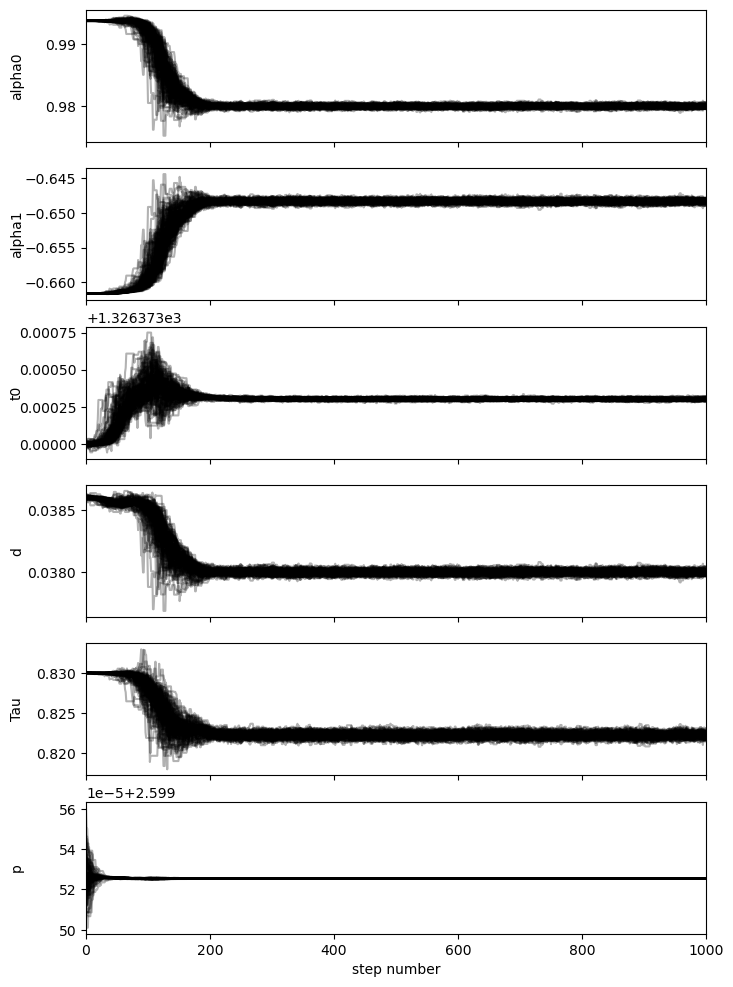

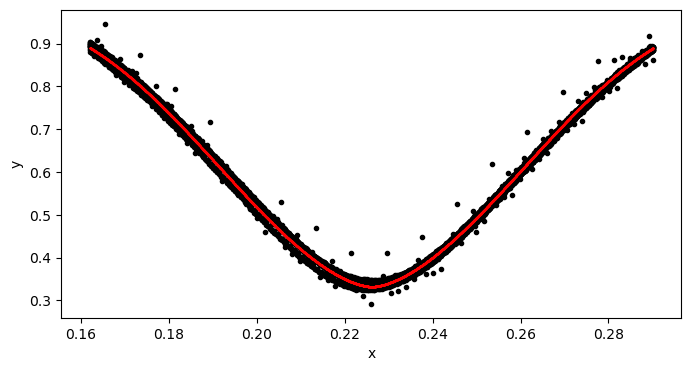

mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 0.980052452265372, -0.6483508662470181, 1326.3733013599162, 0.037997922354195066, 0.8222027775448388, 2.5995255180977836
std_p: 1.494742647195667e-08


In [12]:
# use MCMC to refine the period

use_mcmc_to_fit_period = True


if use_mcmc_to_fit_period:
    import etv_functions_with_period as etvp

    etv_functions.enable_info_log_for_jupyter()
        
    # MCMC result
    mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p, fit_params_p_stats = etvp.run_mcmc_initial_fit_p(
        data_primary[:],
        [0.9937, -0.6616, t0_primary, 0.0386, 0.83, 2.5995257],
        # nruns=20, discard=1, # for a sanity test,  to ensure the initial guess is not way off.
        nruns=1000, discard=600, 
        pool=-2,
        plot_chains=True,
        plot=True,
        also_return_stats=True,
    )
    print("mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p]]))
    print("std_p:", fit_params_p_stats["std_p"])
    !$NOTIFY_CMD "Fitting period done."

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [01:24<00:00, 11.83it/s]


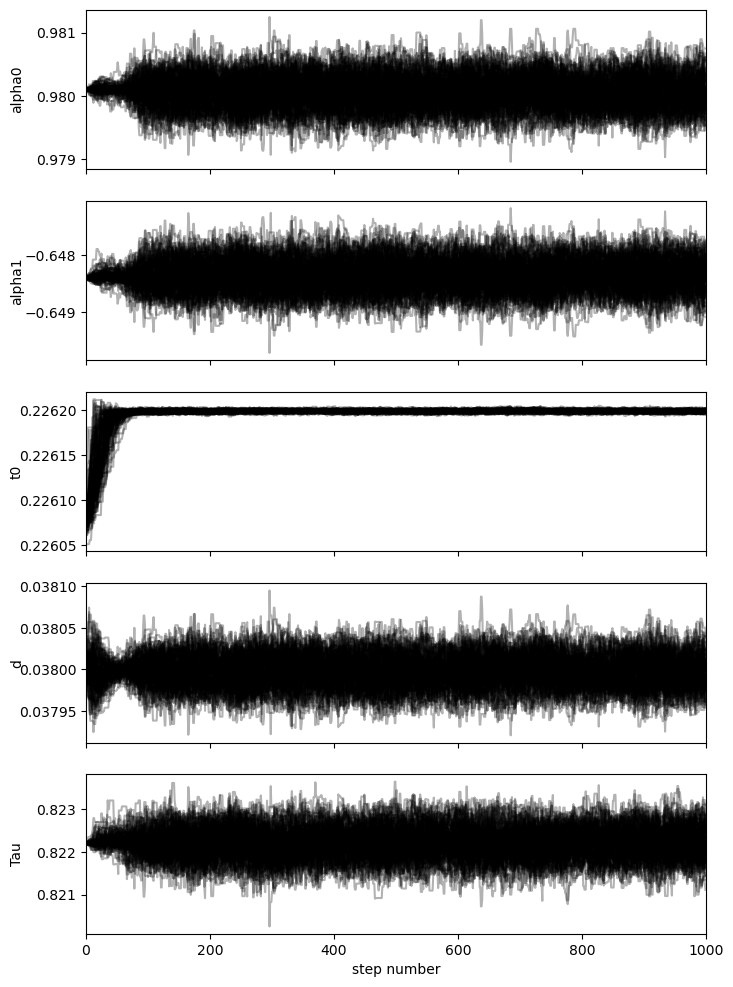

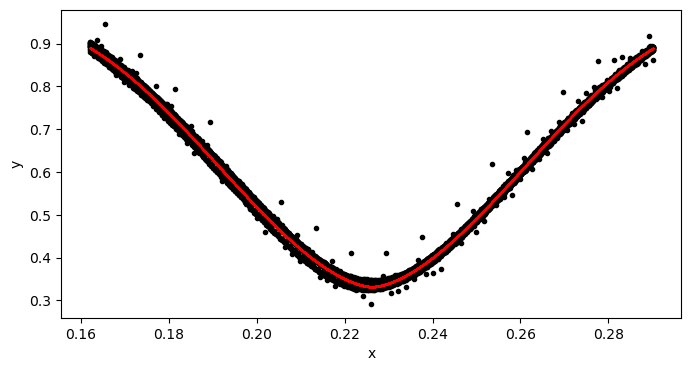

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [01:24<00:00, 11.79it/s]


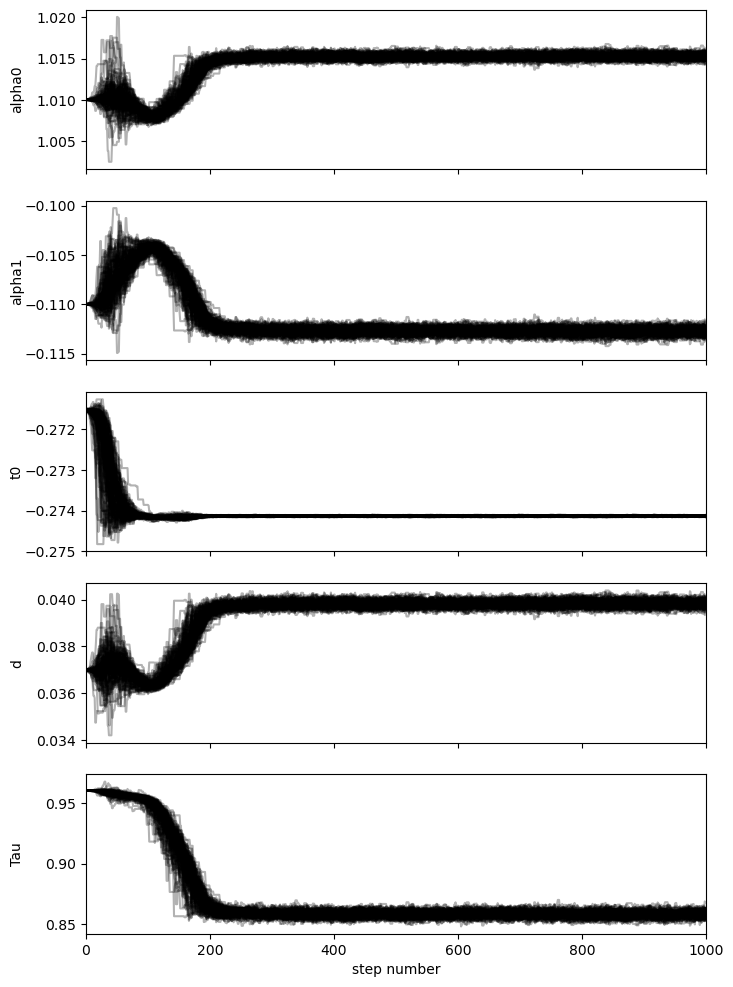

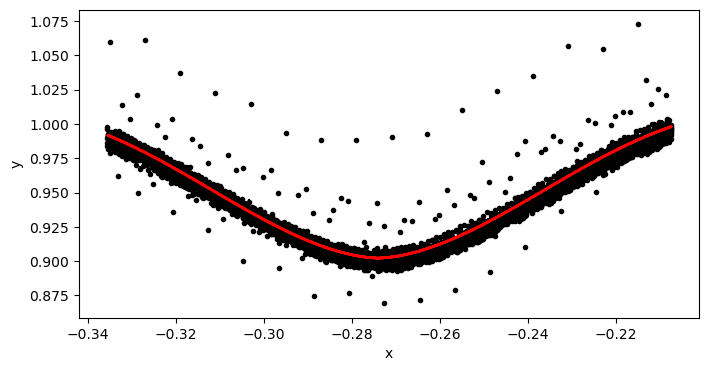

In [15]:
# run the initial model fit using MCMC for the primary and secondary eclipses 
run_init_fit = True

if run_init_fit:
    etv_functions.enable_info_log_for_jupyter()
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = etv_functions.run_mcmc_initial_fit(data_primary, start_vals, nruns=1000, discard=600, pool=-2, plot_chains = True, plot = True)
    if t0_secondary is not None:
        mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = etv_functions.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns=1000, discard=600, pool=-2, plot_chains = True, plot = True)
    !$NOTIFY_CMD "Initial fit done"

In [ ]:
if not run_init_fit:  # case init fit has been previously saved and to be reussed
    print("Use pre-defined inital model params:")
    # # initial fit params from TESS data (with ingress/egress)
    # mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 0.9935150346347841, -0.6613839317759926, 0.22616205766472386, 0.03861877437719097, 0.8228275814105983
    # mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0145797991118573, -0.11178911162137928, -0.27431158774711856, 0.03927433600468548, 0.8759116984789816
    # initial fit params from TESS data (no ingress/egress)
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 0.9800561233871208, -0.6483509273024306, 0.22619870749104531, 0.03799819403069225, 0.8222006699236211
    mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0152580019795232, -0.11270855323064222, -0.2741334870537342, 0.03981964113737796, 0.8584565924439653

    etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *[mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau])
    etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *[mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s])    

In [17]:
print("Initial model params:")  # For information, and they can be copied to the cell above for future reuse

print("mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau]]))
if t0_secondary is not None:
    print("mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = " + ", ".join([str(v) for v in [mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s]]))

Initial model params:
mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 0.9800561233871208, -0.6483509273024306, 0.22619870749104531, 0.03799819403069225, 0.8222006699236211
mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0152580019795232, -0.11270855323064222, -0.2741334870537342, 0.03981964113737796, 0.8584565924439653


702

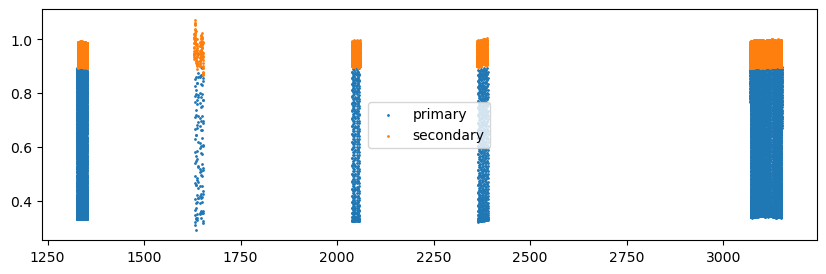

In [18]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(data_primary.time,data_primary.flux , s = 1, label = 'primary')
if t0_secondary is not None:
    plt.scatter(data_secondary.time,data_secondary.flux , s = 1, label = 'secondary')
plt.legend()

# calculate the number of transits there are within the data 
n_transits = int((max(data_primary.time) - min(data_primary.time)) / period)
n_transits

1326.373 2.5995255 1326.373


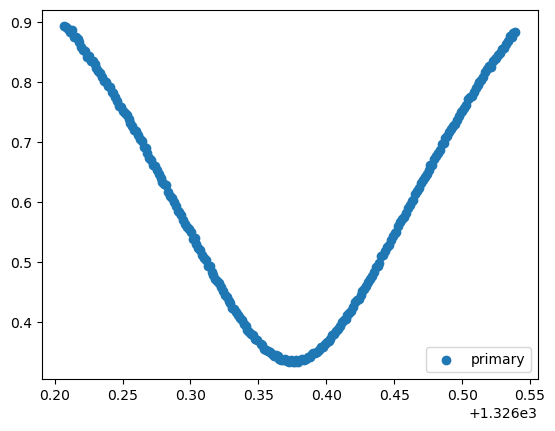

1326.373 2.5995255 1328.9725255


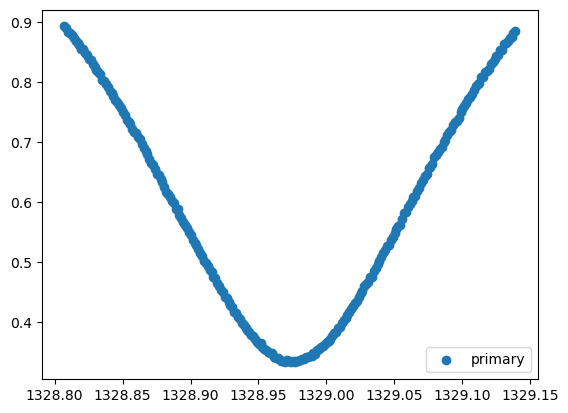

1326.373 2.5995255 1331.572051


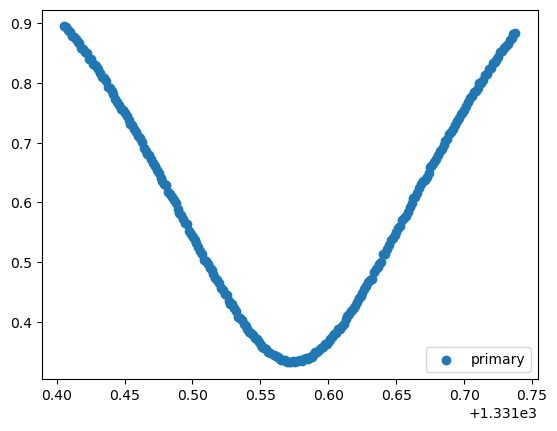

1327.679 2.5995255 1327.679


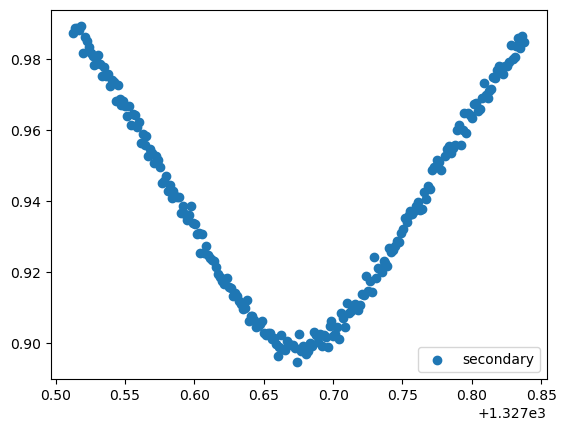

1327.679 2.5995255 1330.2785255000001


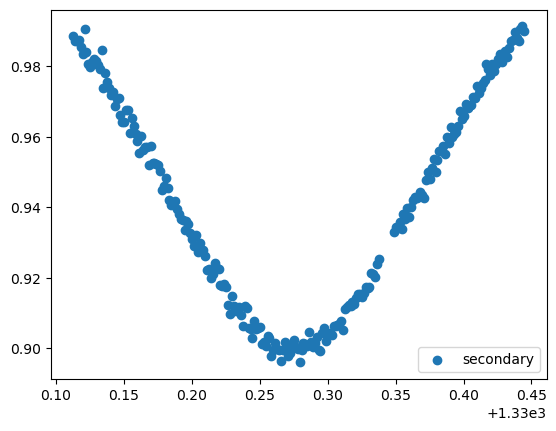

1327.679 2.5995255 1332.8780510000001


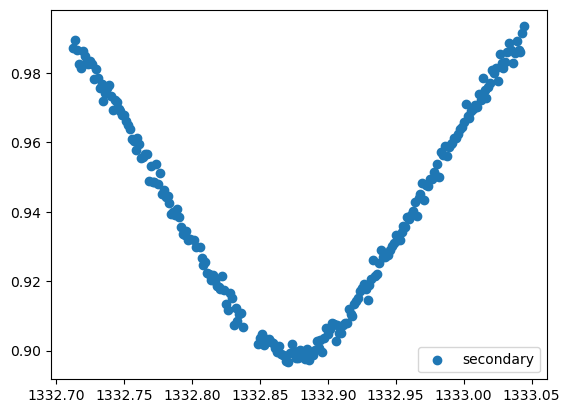

In [19]:
tr_index = range(0,n_transits)

for i in tr_index[0:3]:        
    transit_time = t0_primary+(period*i)
    x = np.array(data_primary.time)
    y = np.array(data_primary.flux) 
    yerr = np.array(data_primary.err)
    
    print (t0_primary, period, transit_time)
    
    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
    
    x = np.array(x[mask])
    y = np.array(y[mask]) 
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="primary")
    plt.legend(loc="lower right")
    plt.show()
    

if t0_secondary is not None:
    for i in tr_index[0:3]:        
        transit_time = t0_secondary+(period*i)
        x = np.array(data_secondary.time)
        y = np.array(data_secondary.flux) 
        yerr = np.array(data_secondary.err)
        
        print (t0_secondary, period, transit_time)
        
        mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
        
        x = np.array(x[mask])
        y = np.array(y[mask]) 
        yerr = np.array(yerr[mask])
        fig, ax = plt.subplots()
        plt.scatter(x,y, label="secondary")
        plt.legend(loc="lower right")
        plt.show()

Fitting individual primary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 0 has already been completed -- skip
1328.9725255 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 311.64it/s]


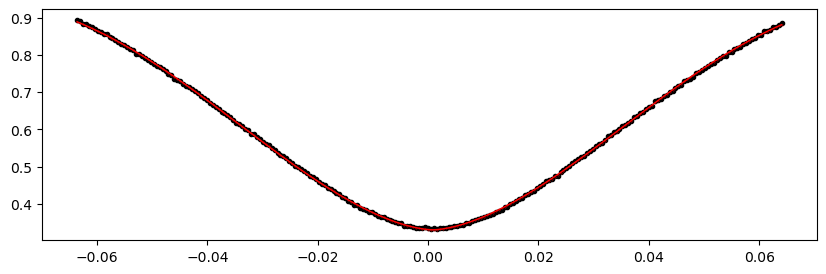

1331.572051 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 312.69it/s]


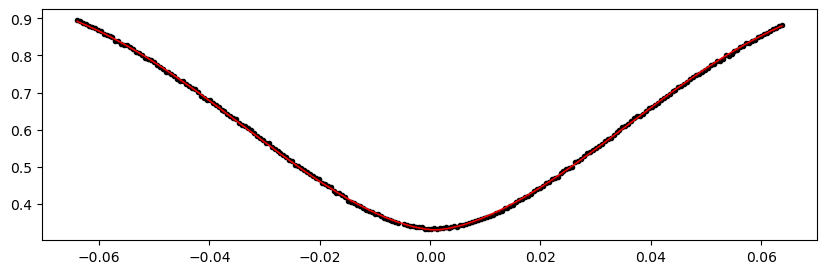

1334.1715765000001 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 305.52it/s]


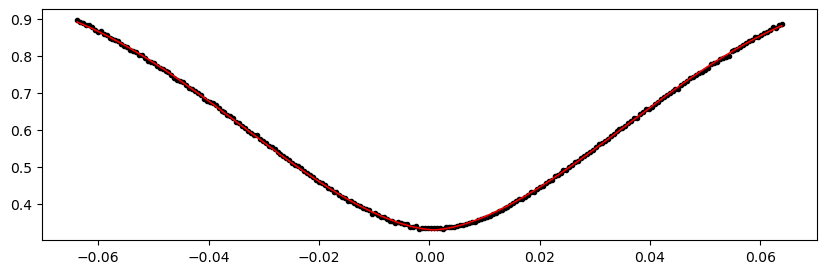

1336.7711020000002 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 309.72it/s]


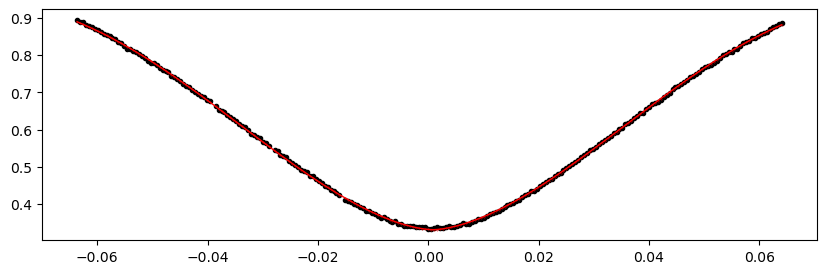

1341.970153 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 318.20it/s]


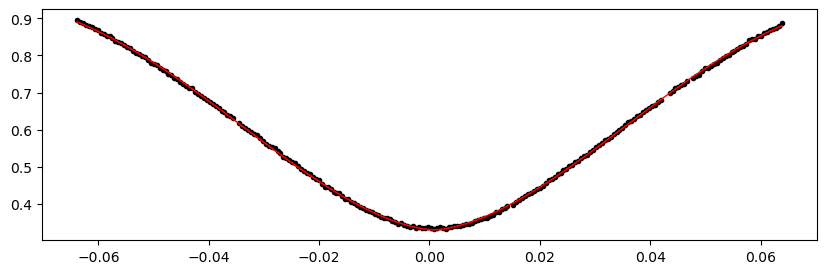

1344.5696785 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 299.59it/s]


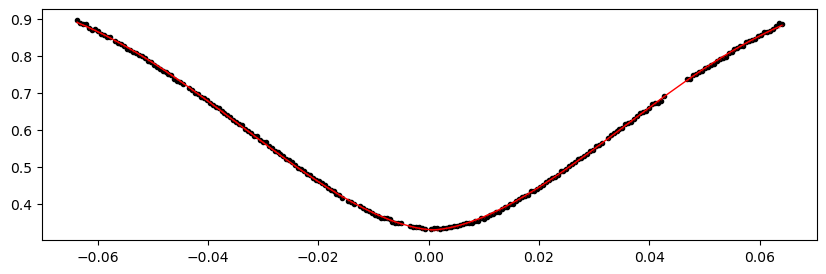

1347.169204 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 313.68it/s]


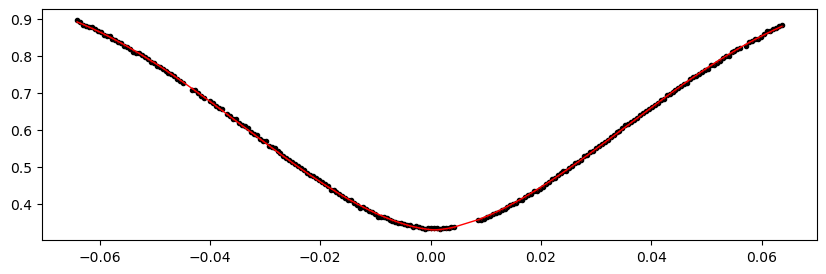

1349.7687295 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 316.68it/s]


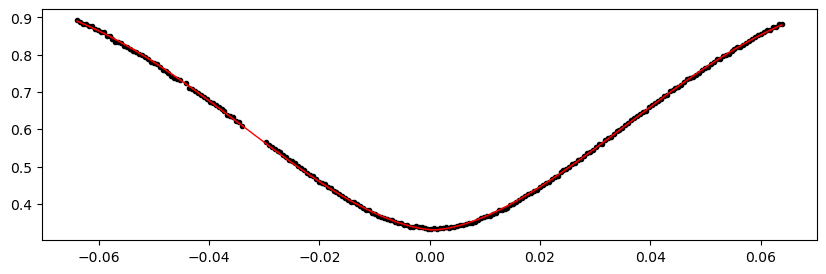

1352.368255 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 315.22it/s]


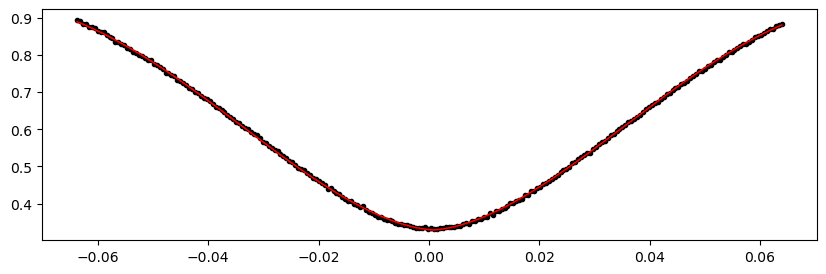

1630.5174835 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 436.96it/s]


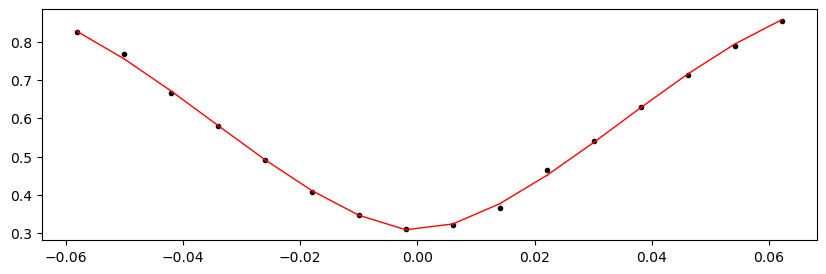

1633.117009 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 443.45it/s]


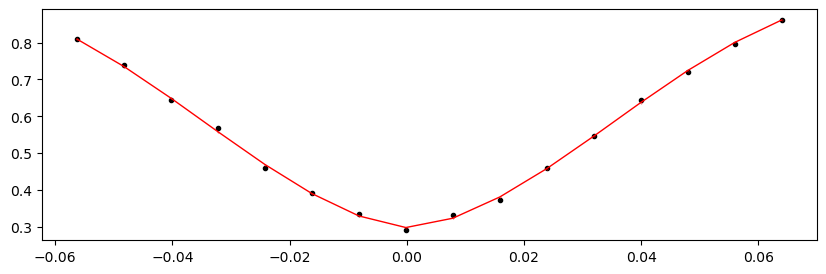

1635.7165345 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 446.75it/s]


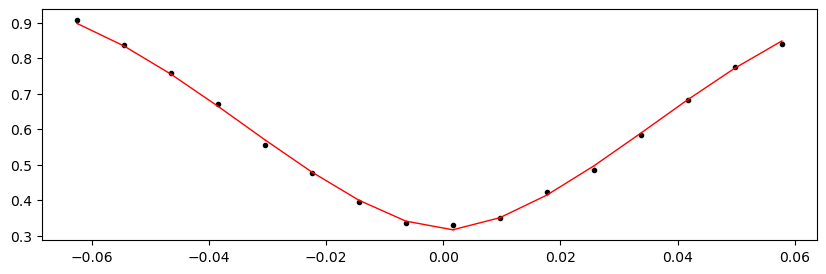

1638.31606 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 446.11it/s]


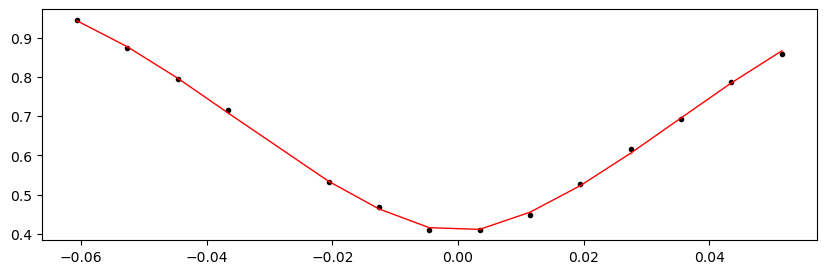

1643.5151110000002 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 449.08it/s]


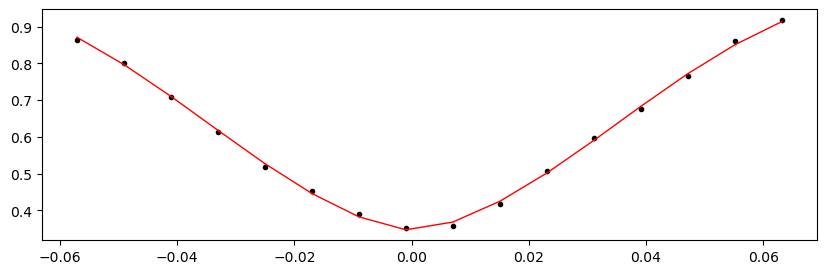

1646.1146365 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 446.86it/s]


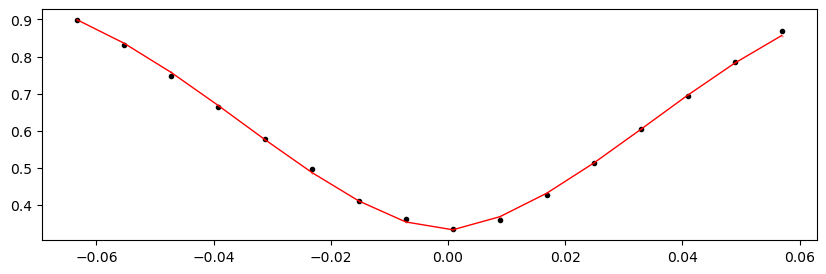

1648.714162 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 443.29it/s]


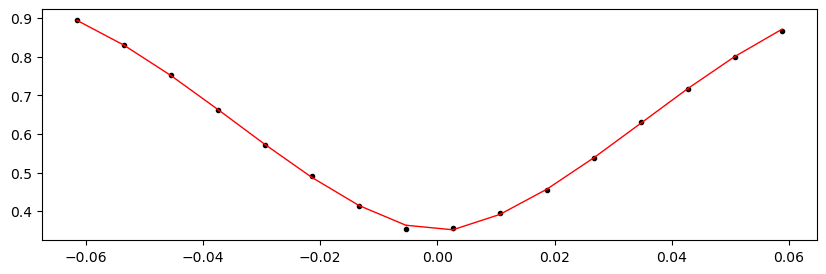

1651.3136875 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 444.83it/s]


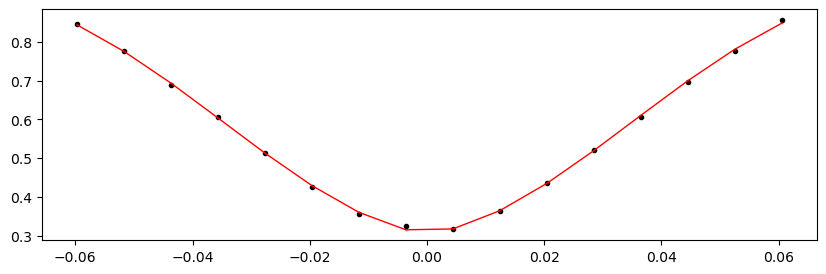

2038.6429870000002 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.90it/s]


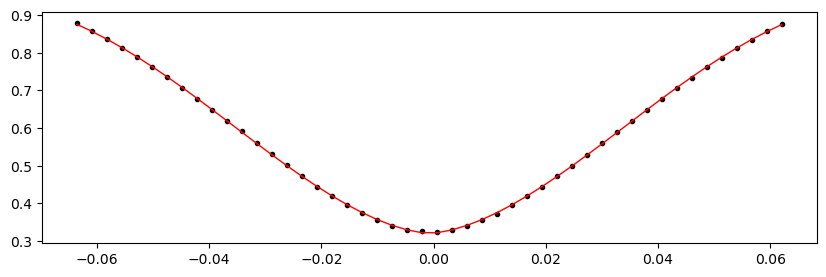

2041.2425125 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 423.00it/s]


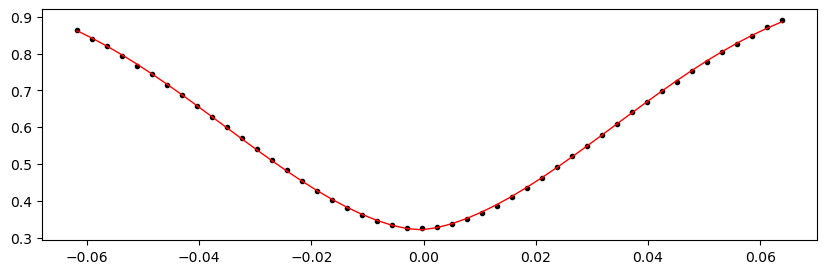

2043.842038 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 421.22it/s]


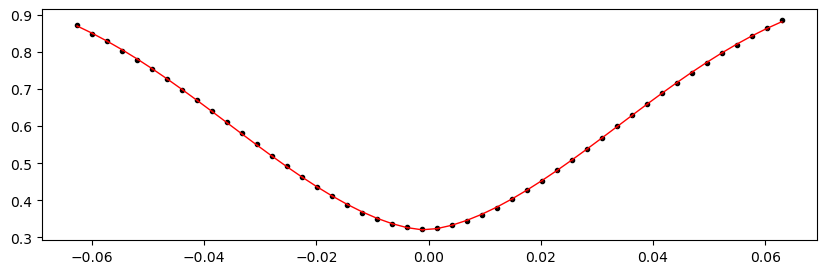

2046.4415635 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 428.37it/s]


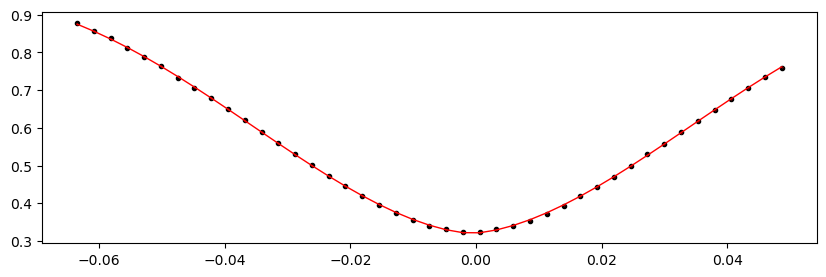

Time 2049.0410890000003 does not have enough data points: 7
2051.6406145 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.10it/s]


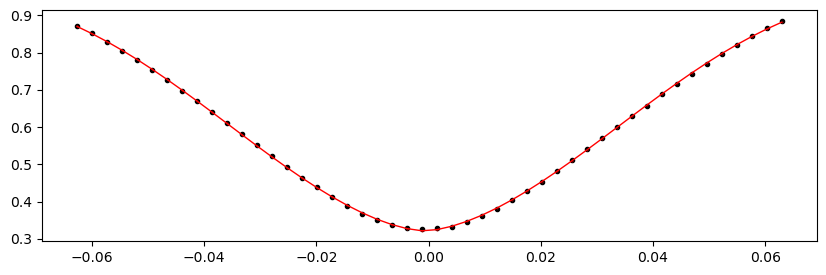

2054.24014 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.21it/s]


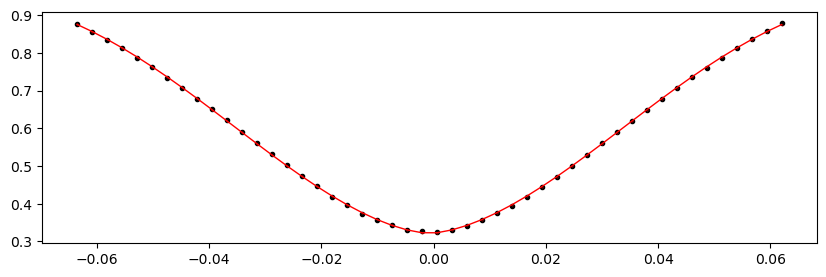

2056.8396655 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.68it/s]


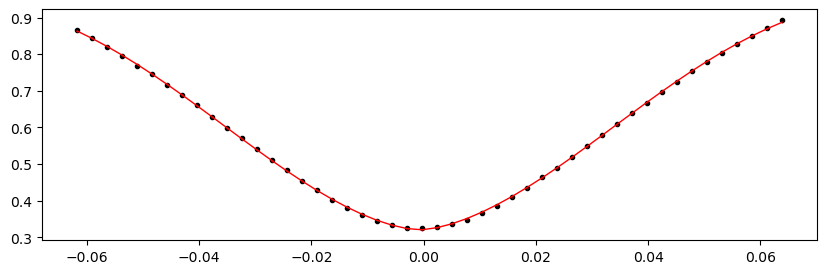

2363.5836744999997 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.55it/s]


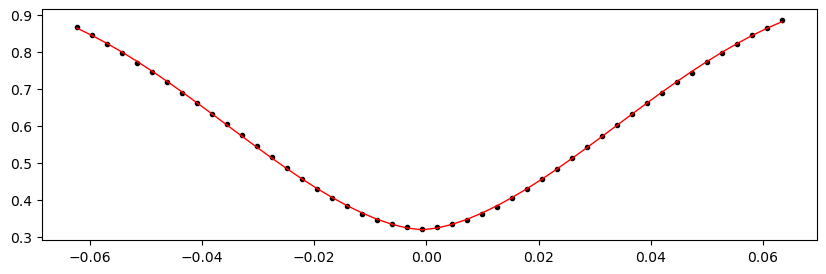

2366.1832 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 423.23it/s]


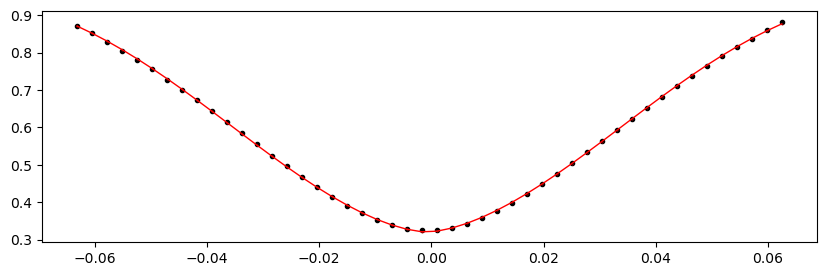

2368.7827255 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.09it/s]


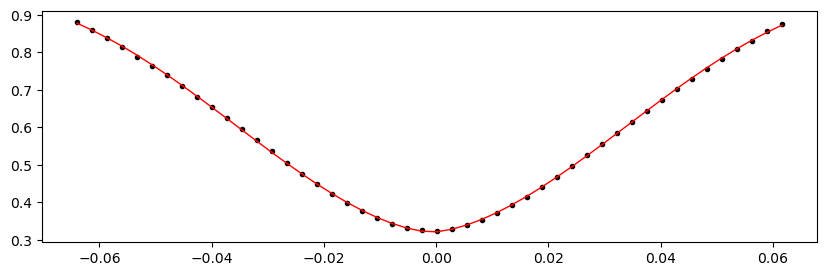

2371.382251 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 423.28it/s]


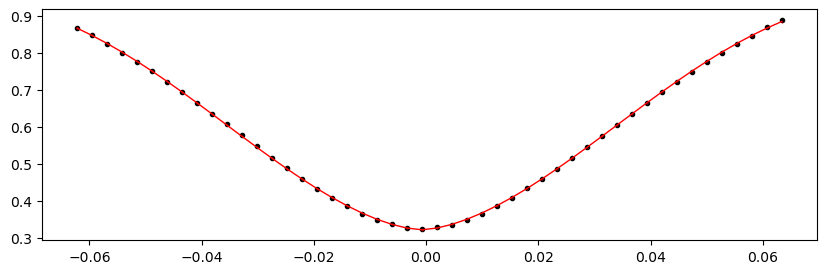

2373.9817765 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 423.25it/s]


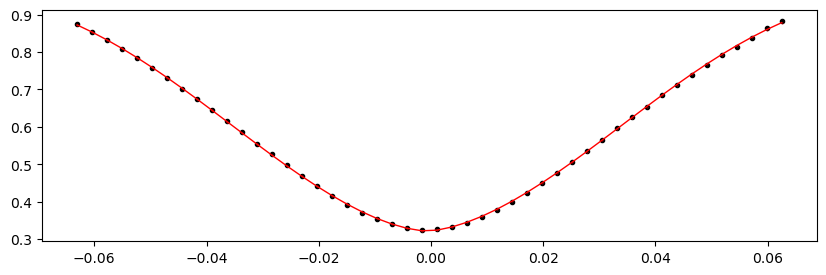

2376.581302 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.30it/s]


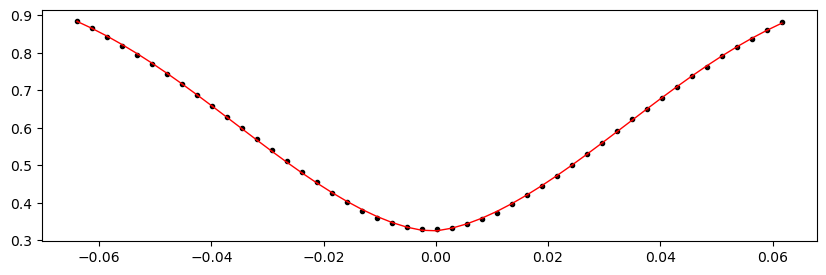

2379.1808275000003 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.65it/s]


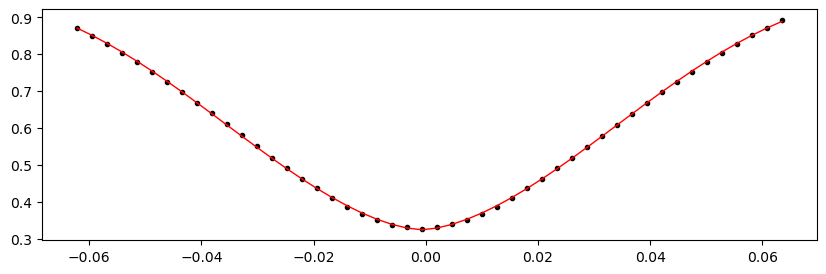

2381.780353 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.01it/s]


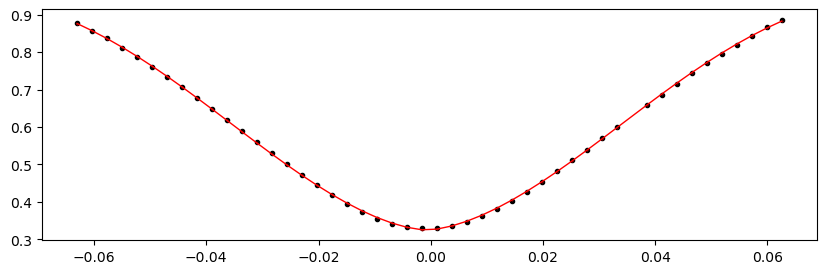

2384.3798785 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.94it/s]


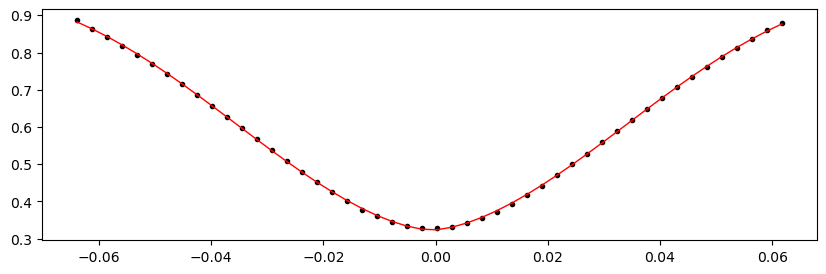

2386.9794039999997 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.66it/s]


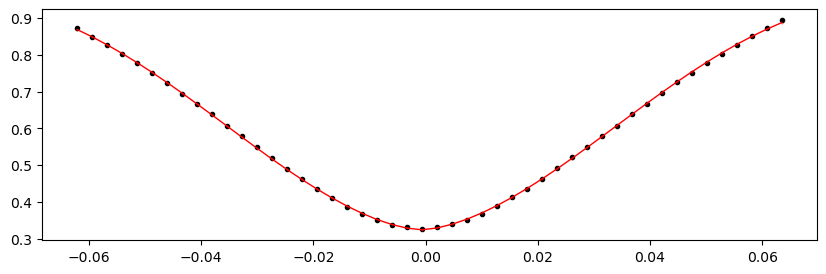

2389.5789295 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 431.72it/s]


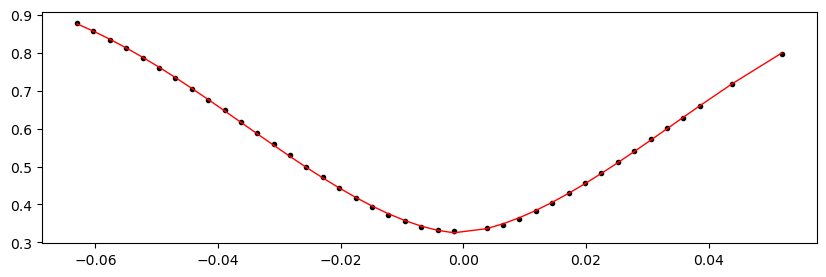

3070.6546104999998 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 324.35it/s]


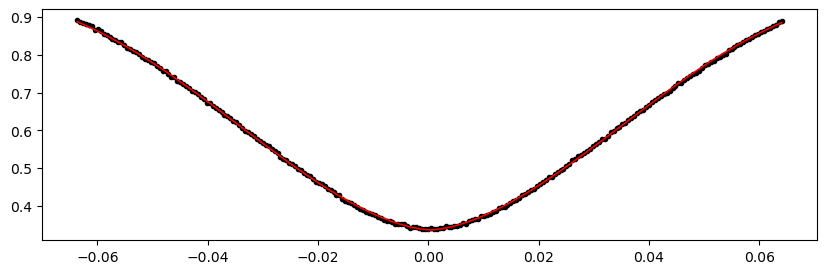

3073.254136 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.71it/s]


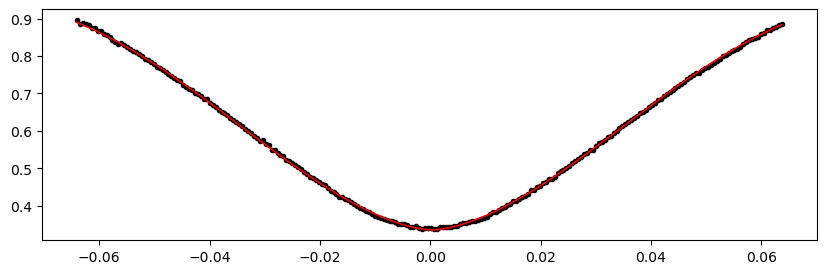

3075.8536615000003 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 337.19it/s]


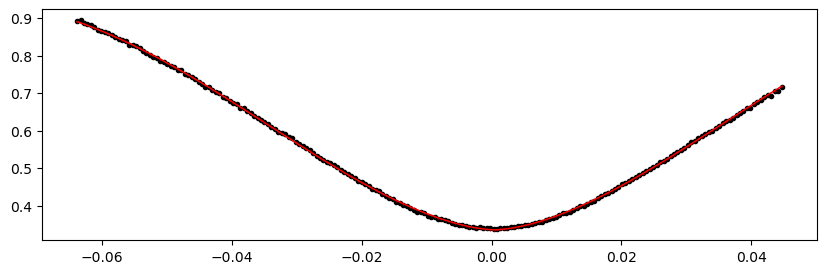

3078.453187 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.76it/s]


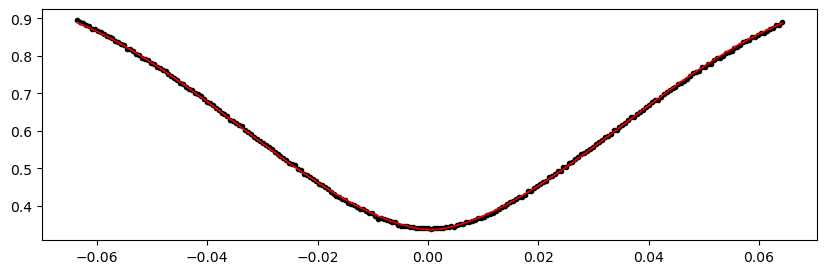

3081.0527125 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.83it/s]


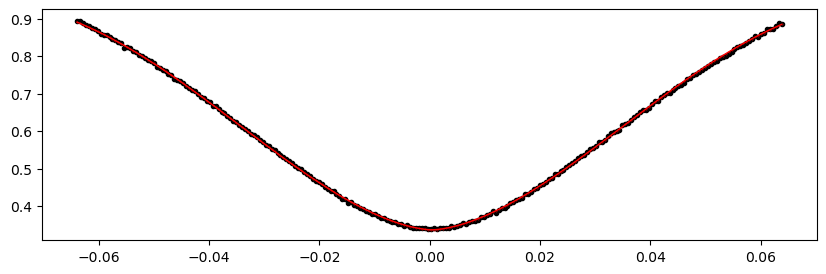

3083.6522379999997 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.14it/s]


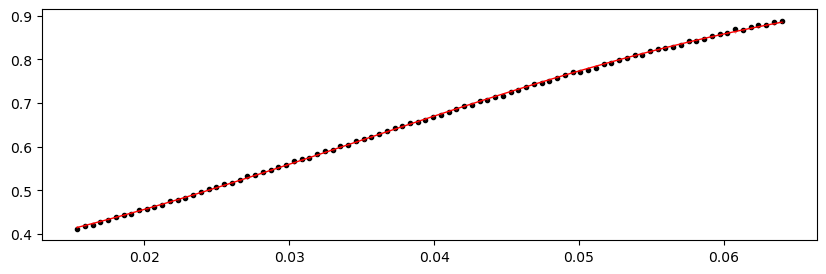

3086.2517635 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 324.52it/s]


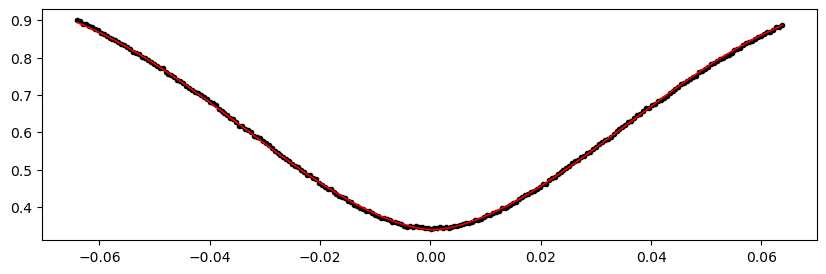

3088.851289 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 324.60it/s]


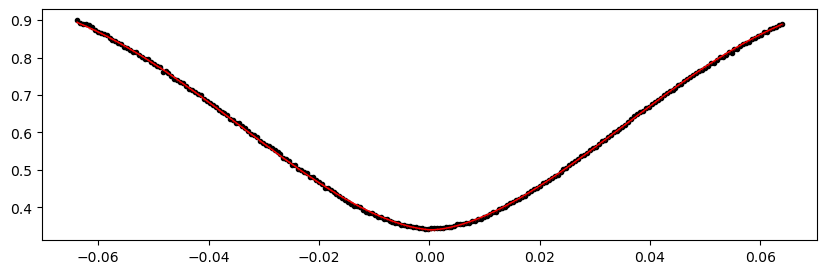

3091.4508145 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 324.31it/s]


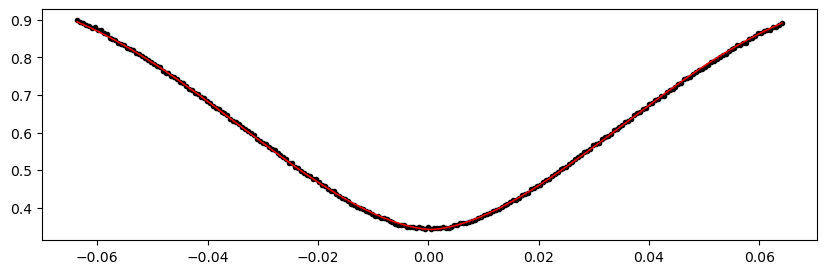

3094.05034 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 325.15it/s]


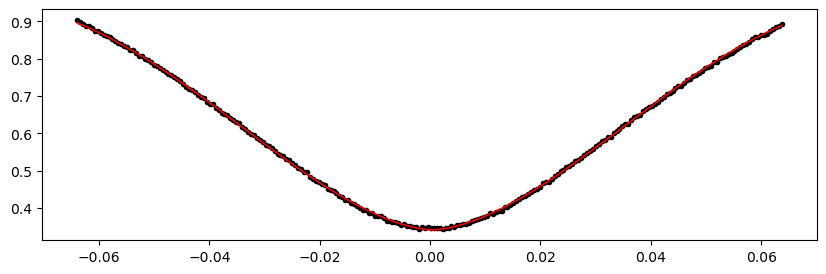

3099.2493910000003 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.67it/s]


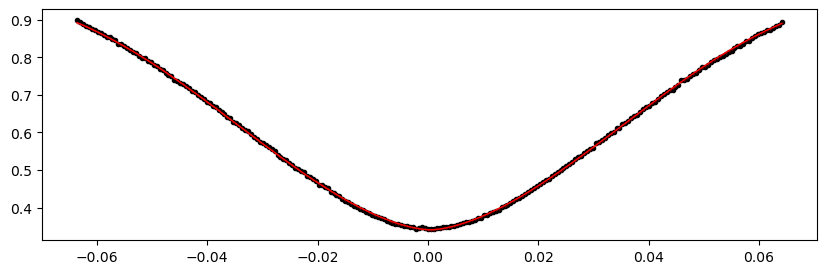

3101.8489165 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 322.69it/s]


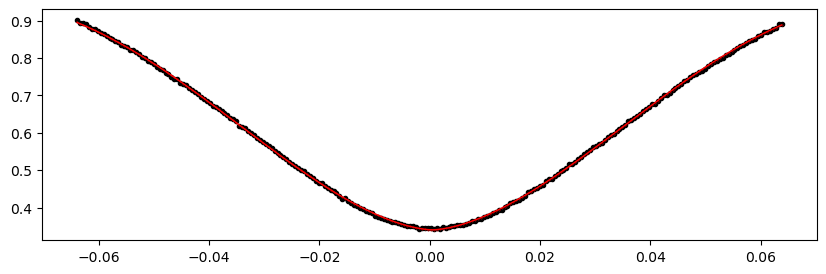

3104.448442 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 322.13it/s]


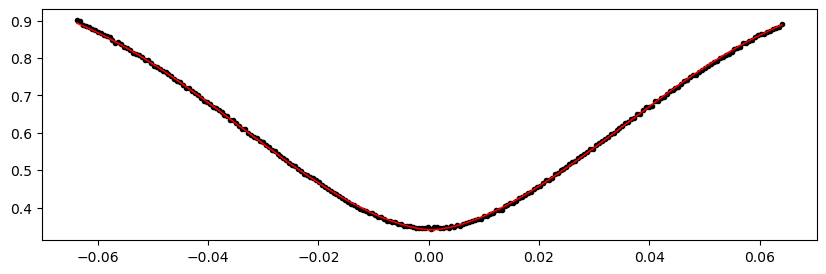

3107.0479674999997 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 324.51it/s]


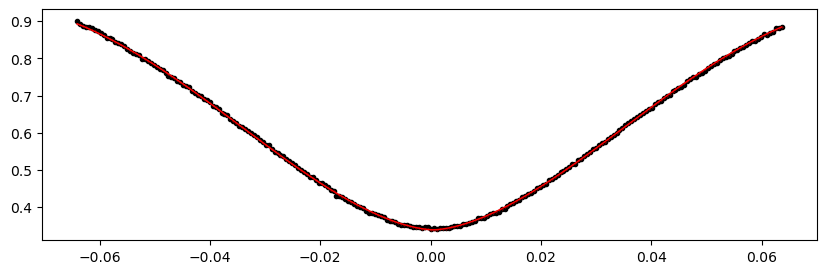

3112.2470185 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 354.94it/s]


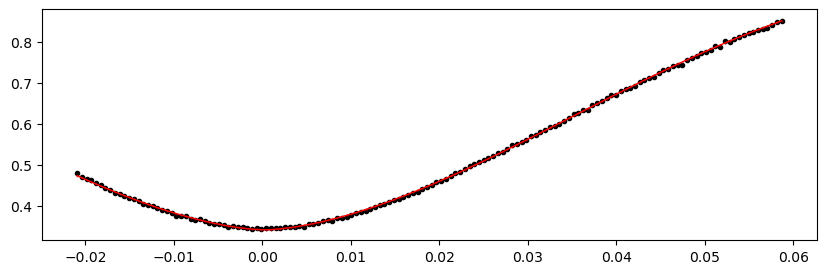

3114.846544 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 322.19it/s]


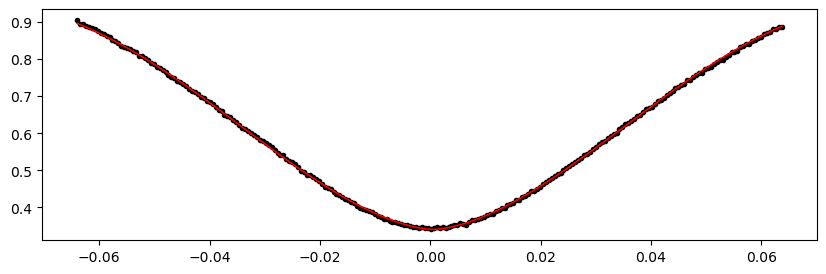

3117.4460695 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.59it/s]


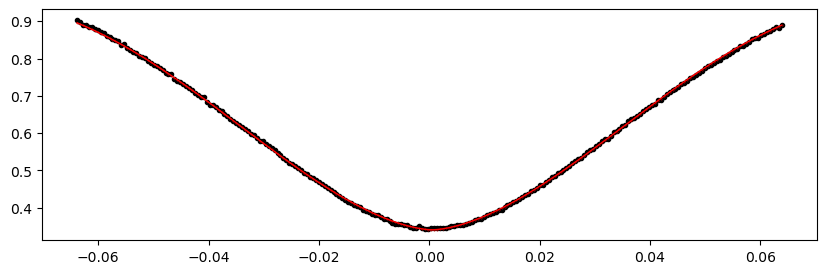

3120.045595 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:34<00:00, 288.18it/s]


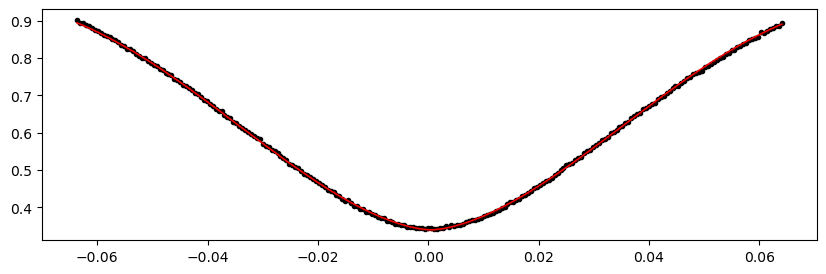

3127.8441715 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:41<00:00, 243.14it/s]


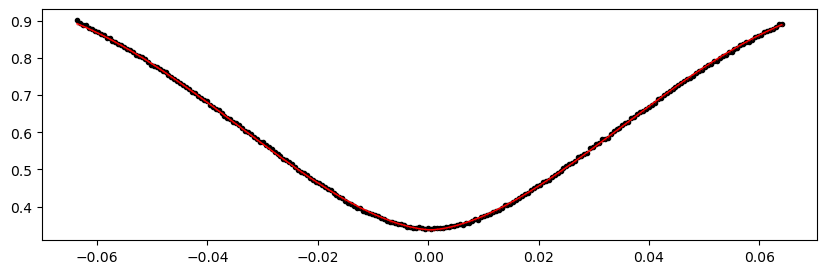

3130.4436969999997 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 324.67it/s]


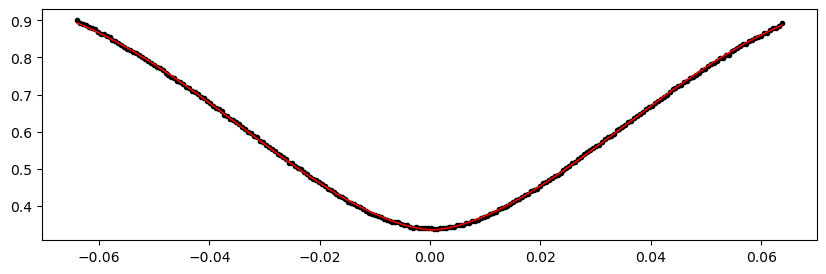

3133.0432225 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.85it/s]


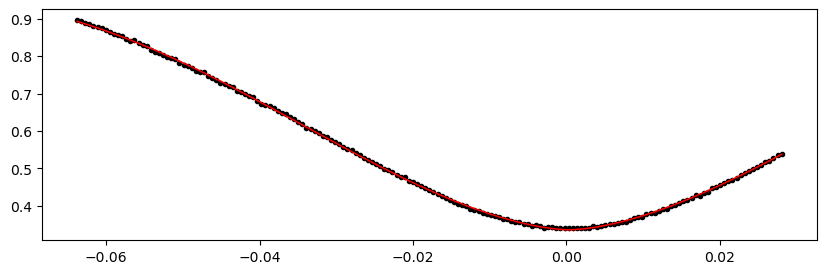

3135.642748 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 319.33it/s]


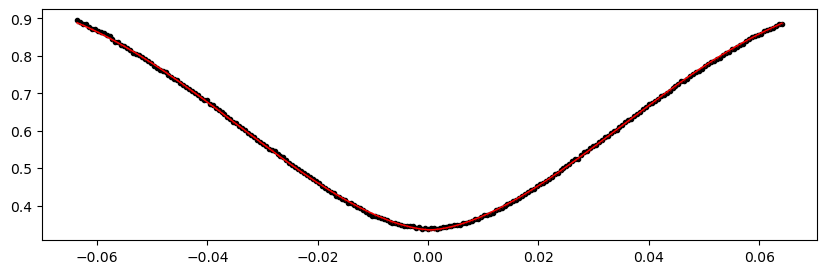

3140.841799 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 321.79it/s]


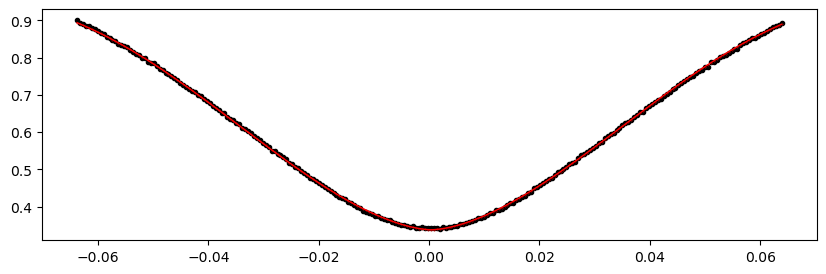

3143.4413245 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 322.15it/s]


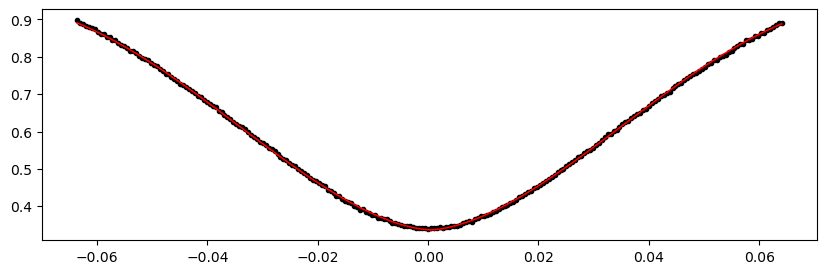

3146.0408500000003 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 322.47it/s]


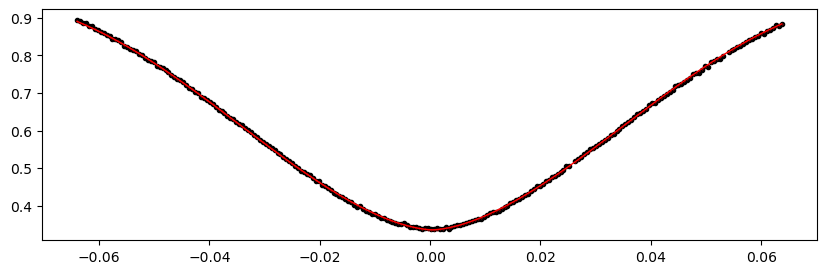

3148.6403755 0.9800561233871208 -0.6483509273024306 0.22619870749104531


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 319.56it/s]


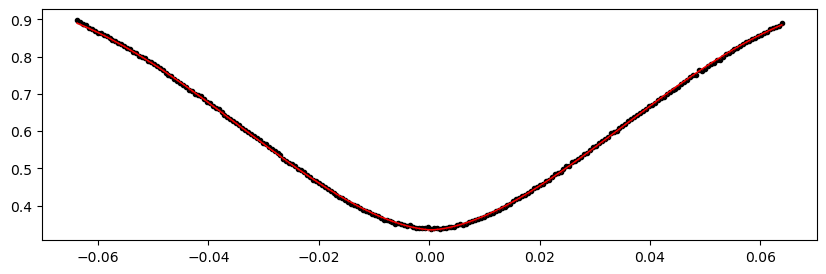

In [22]:
%matplotlib inline

# from importlib import reload
# reload(etv_functions)

print("Fitting individual primary eclipses...")
etv_functions.fit_each_eclipse(data_primary, n_transits, t0_primary, period, mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, outfile_path,
                               min_number_data=13,  # accomodate 1 sector of 30 min cadence data
                              )
!$NOTIFY_CMD "Individual primary eclipses fit done"


Fitting individual secondary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 0 has already been completed -- skip
1330.2785255000001 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 321.44it/s]


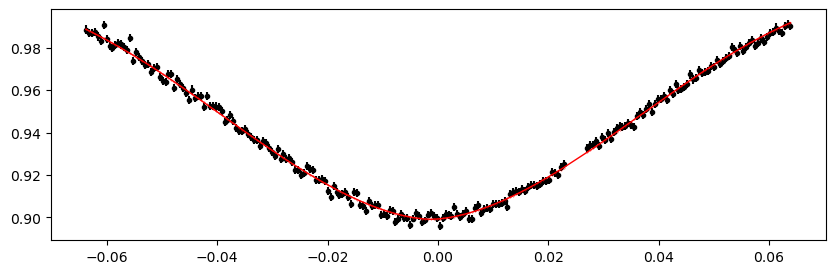

1332.8780510000001 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 319.86it/s]


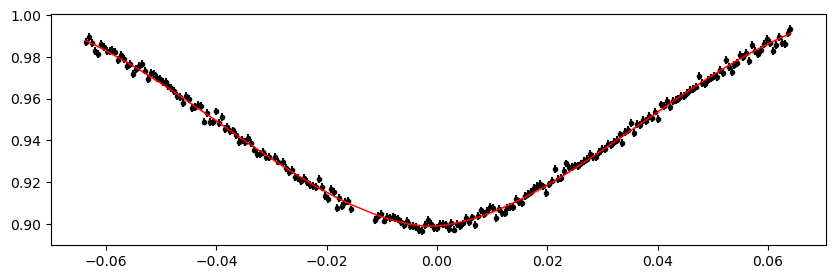

1335.4775765000002 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:36<00:00, 276.42it/s]


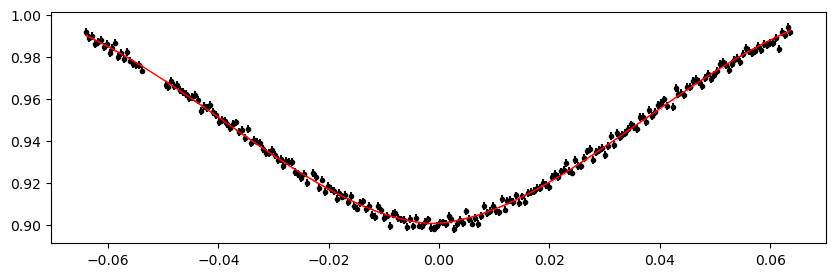

1338.0771020000002 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:34<00:00, 292.50it/s]


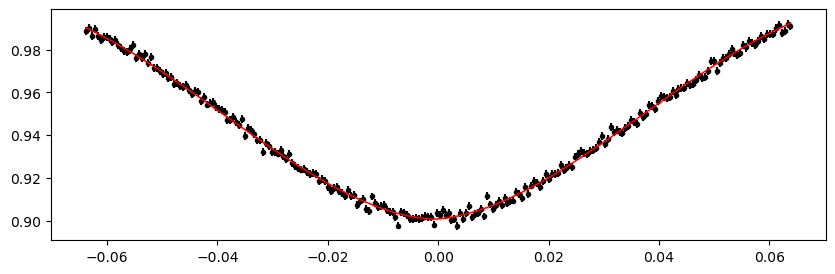

1340.6766275 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 318.35it/s]


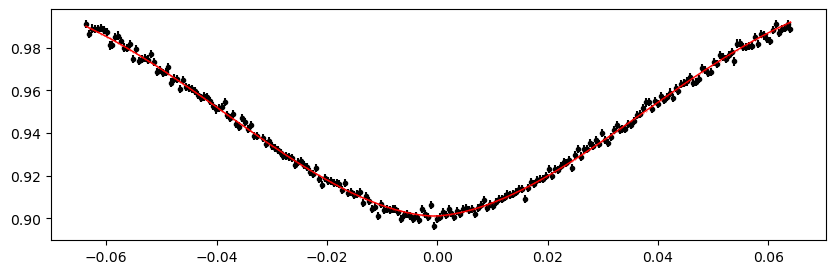

1343.276153 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.04it/s]


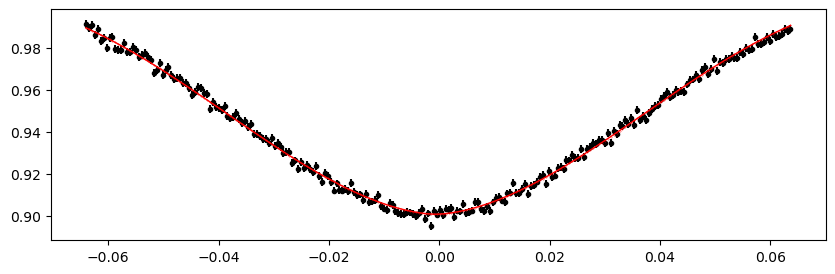

1345.8756785 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 325.58it/s]


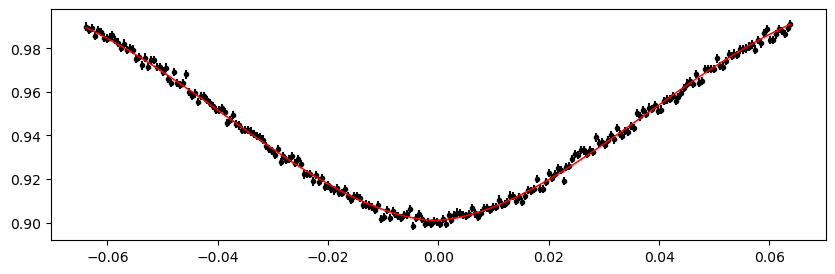

1348.475204 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 385.53it/s]


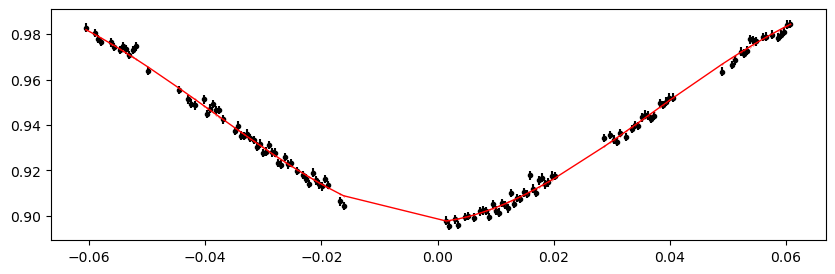

1351.0747295 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 326.54it/s]


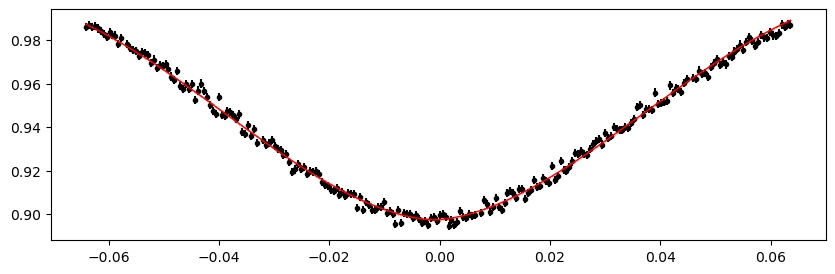

1629.223958 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 448.33it/s]


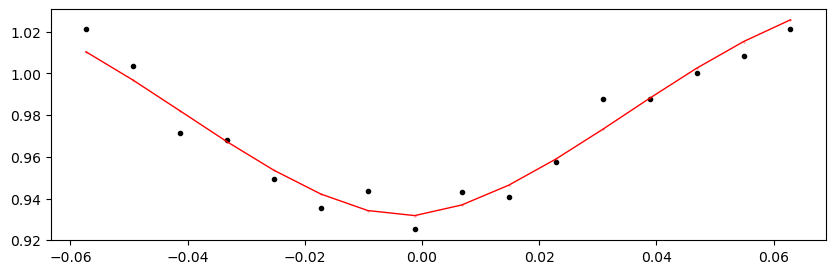

1631.8234835 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:16<00:00, 588.28it/s]


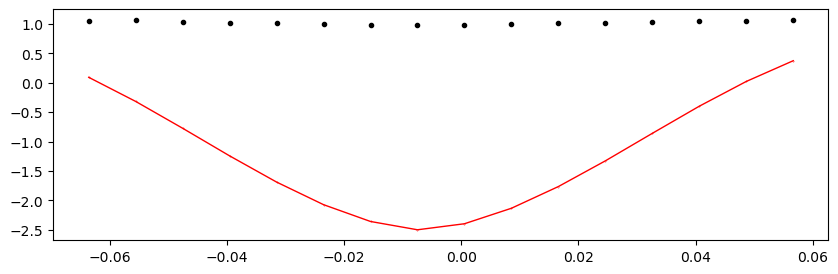

1634.423009 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 446.71it/s]


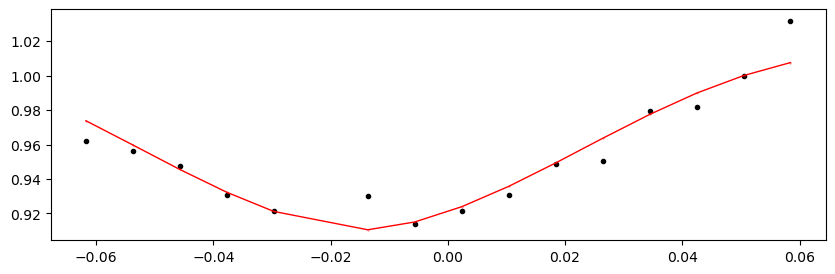

1637.0225345000001 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 446.57it/s]


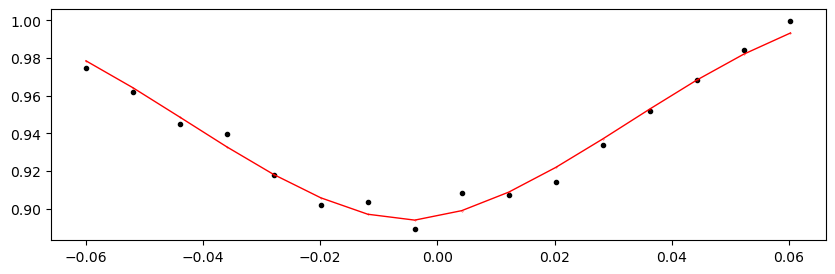

1644.8211110000002 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 448.02it/s]


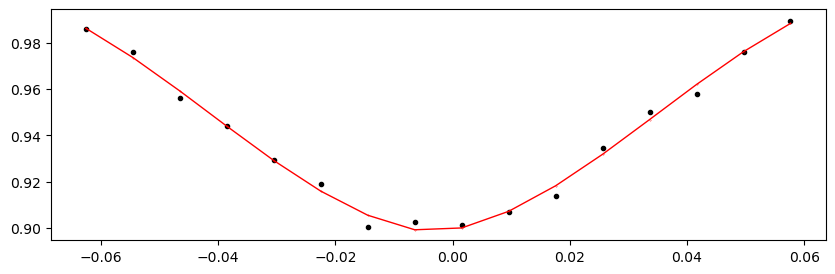

1647.4206365 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 449.90it/s]


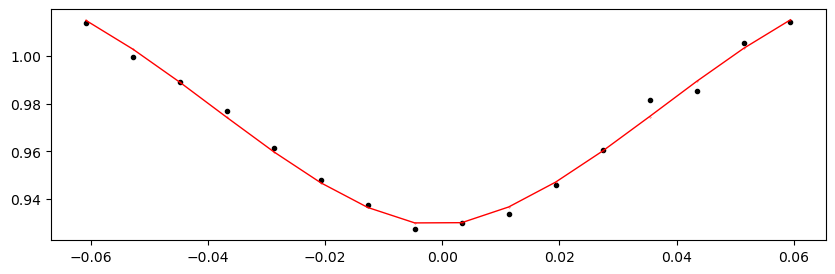

1650.020162 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 446.72it/s]


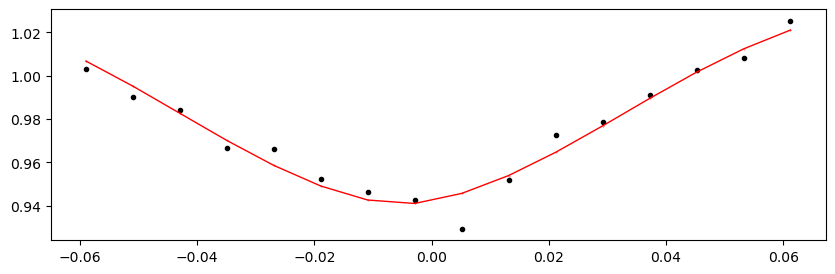

1652.6196875 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 451.45it/s]


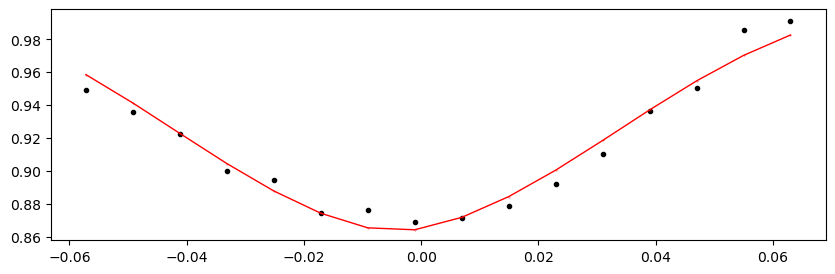

2037.3494615 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.76it/s]


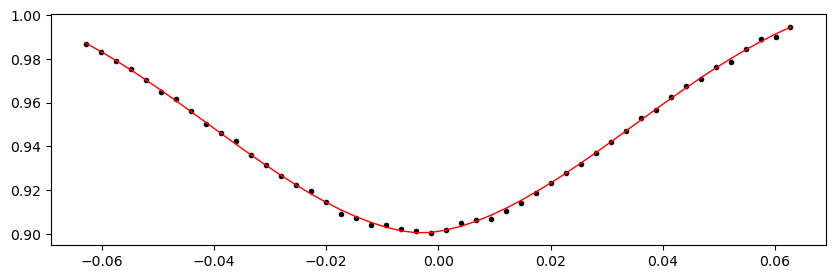

2039.9489870000002 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.11it/s]


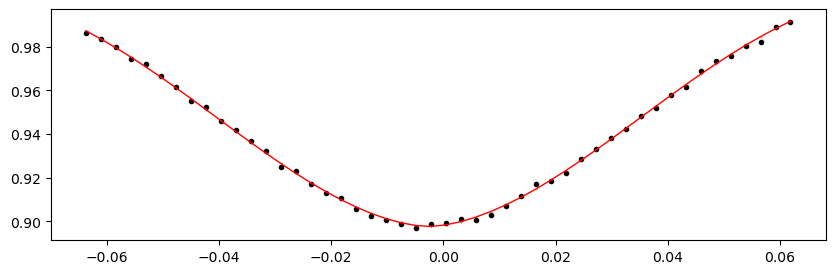

2042.5485125 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 423.54it/s]


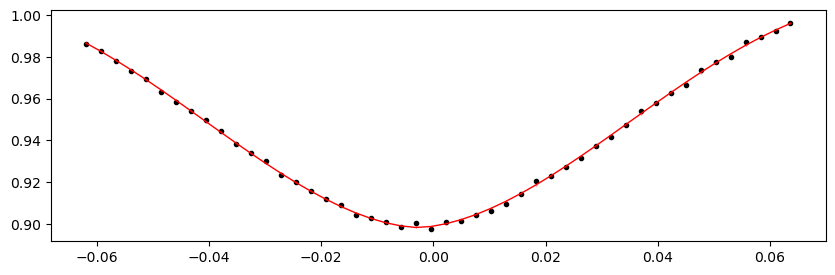

2045.148038 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 428.41it/s]


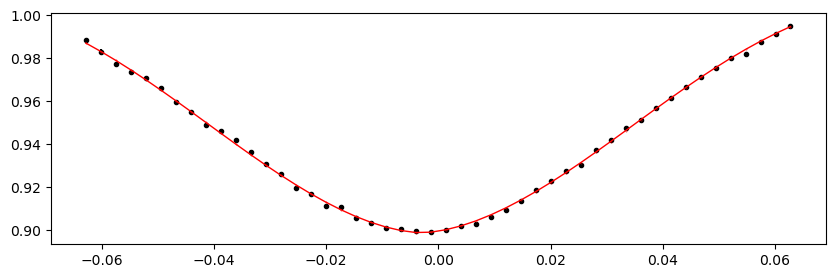

2050.347089 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 427.28it/s]


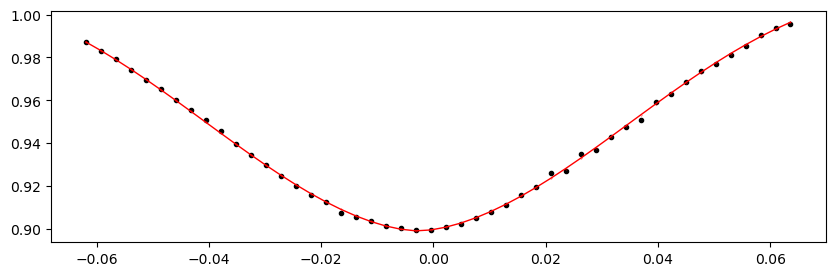

2052.9466145 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.44it/s]


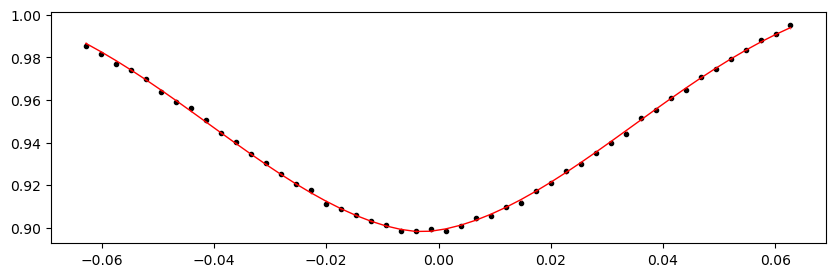

2055.54614 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.92it/s]


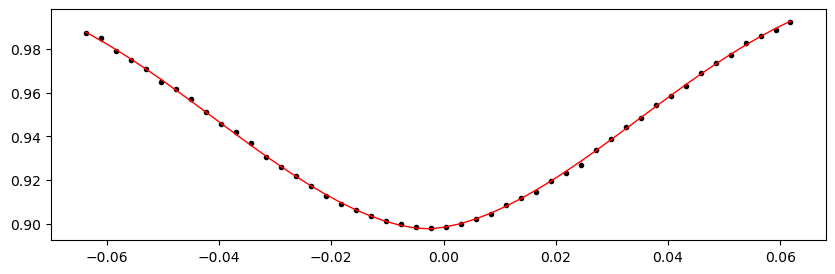

2058.1456655 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.11it/s]


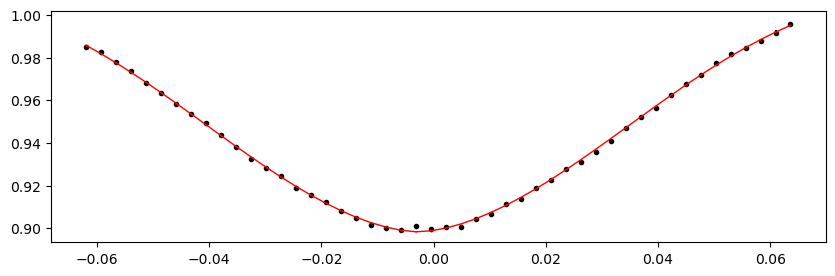

2362.2901490000004 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 427.27it/s]


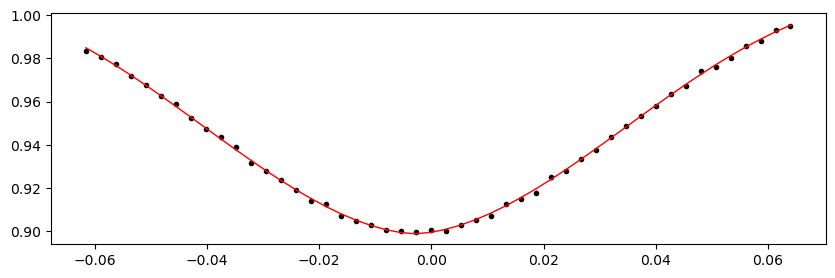

2364.8896745 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.99it/s]


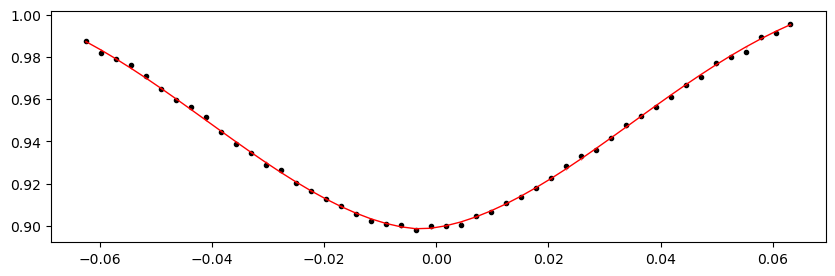

2367.4892 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.13it/s]


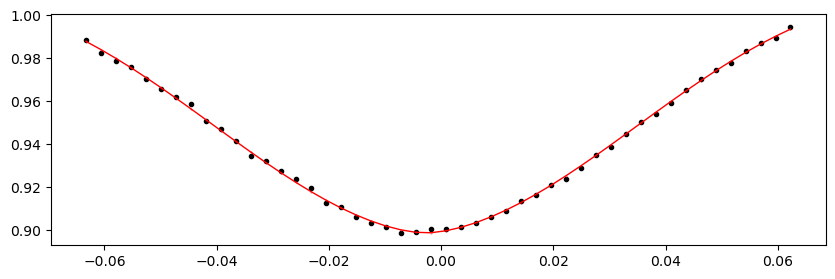

2370.0887255 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 420.81it/s]


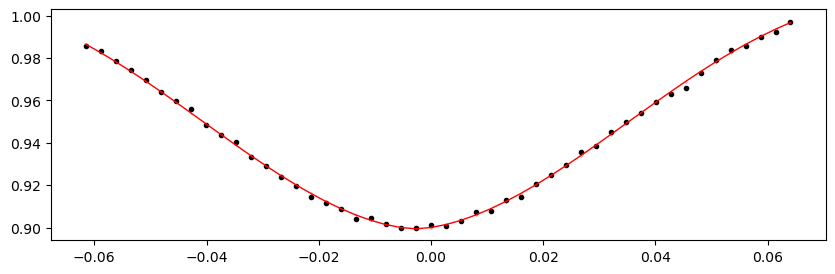

2372.688251 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.69it/s]


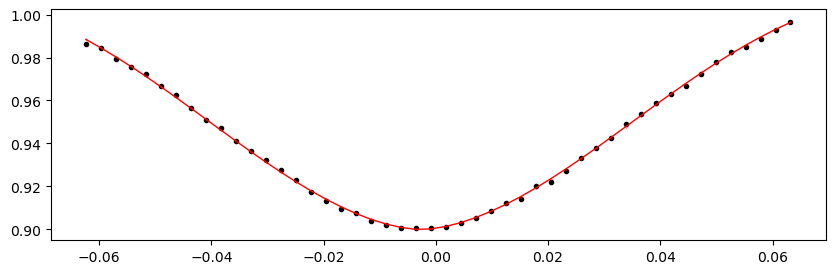

2377.887302 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 422.06it/s]


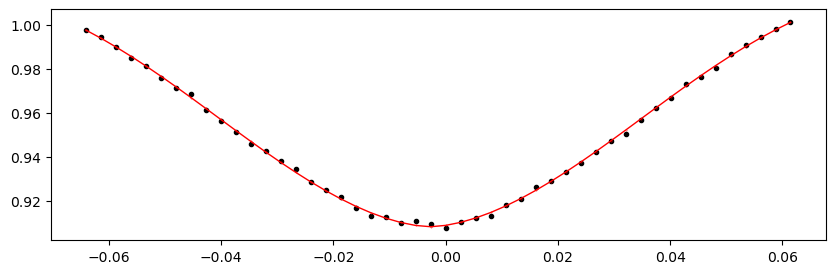

2380.4868275 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.65it/s]


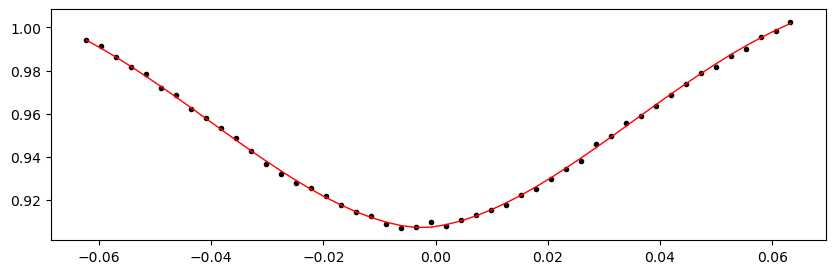

2383.086353 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.15it/s]


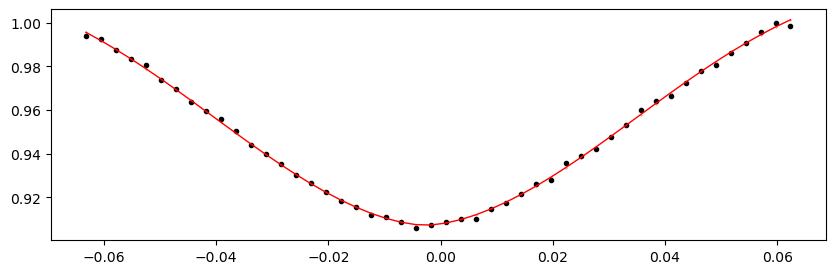

2385.6858785000004 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 427.50it/s]


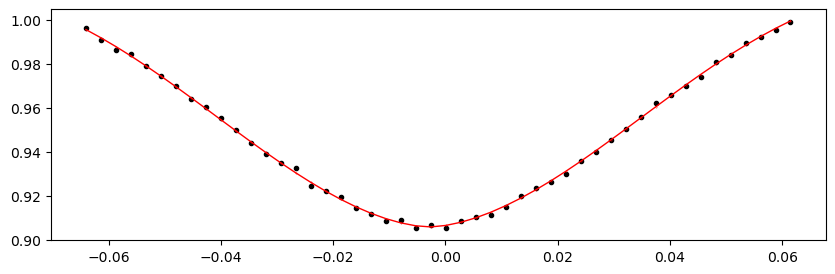

2388.285404 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.41it/s]


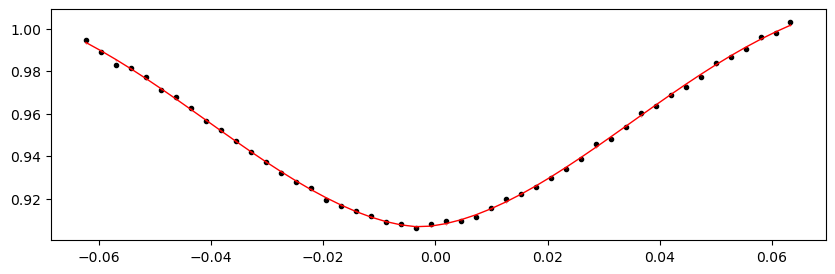

3069.361085 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 325.03it/s]


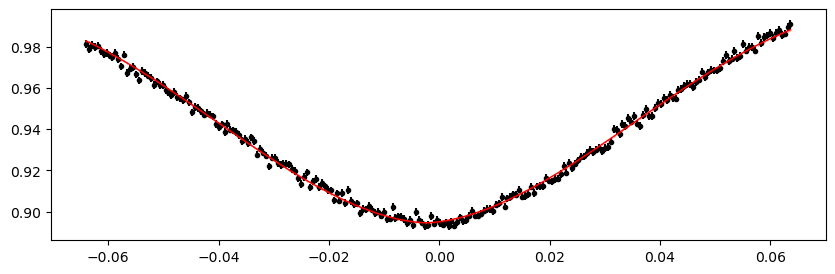

3071.9606105000003 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 325.21it/s]


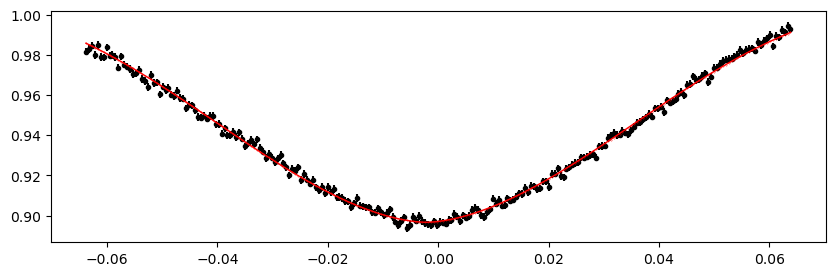

3074.560136 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 324.14it/s]


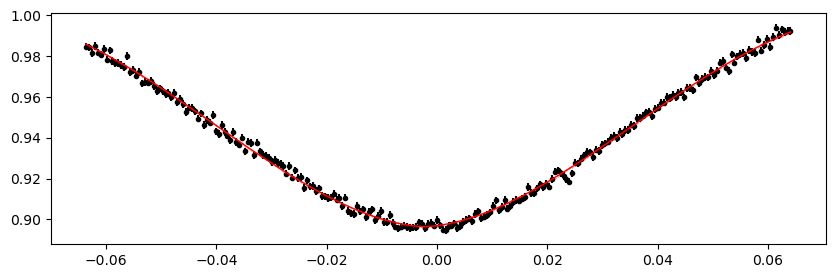

3077.1596615 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 325.69it/s]


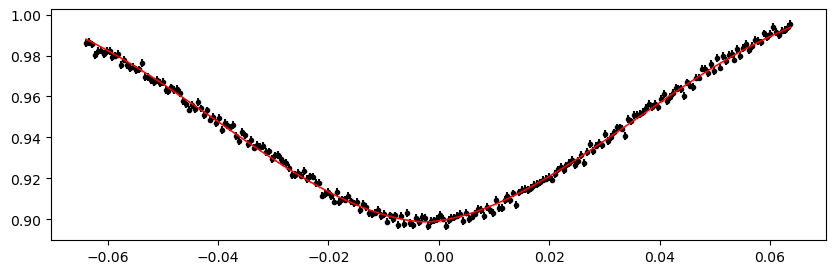

3079.759187 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 325.80it/s]


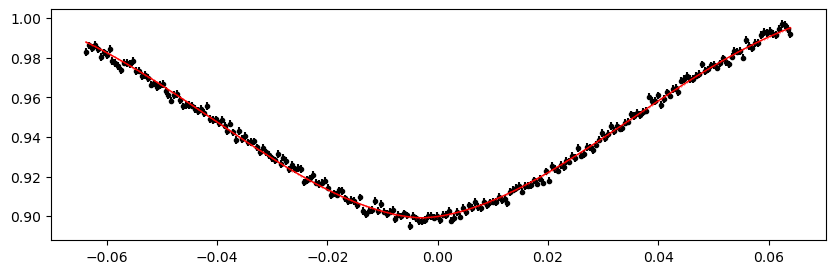

3082.3587125000004 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 324.08it/s]


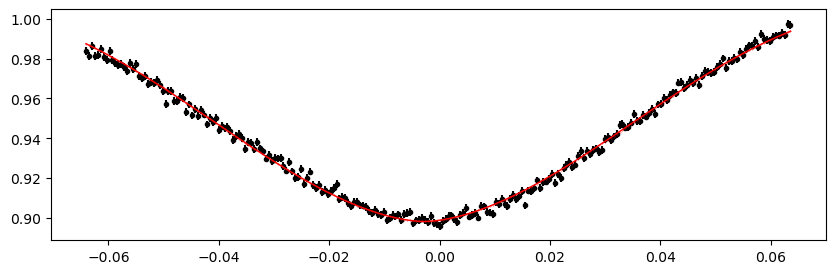

3084.958238 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.46it/s]


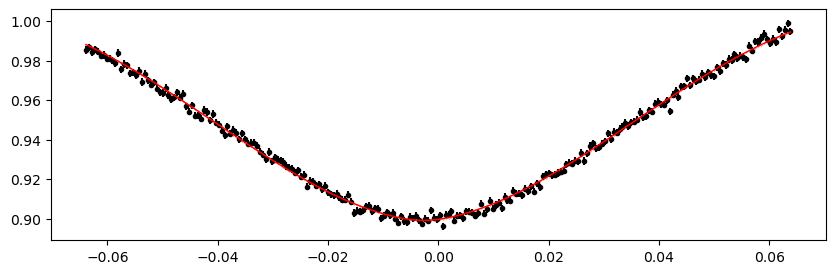

3087.5577635 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 326.22it/s]


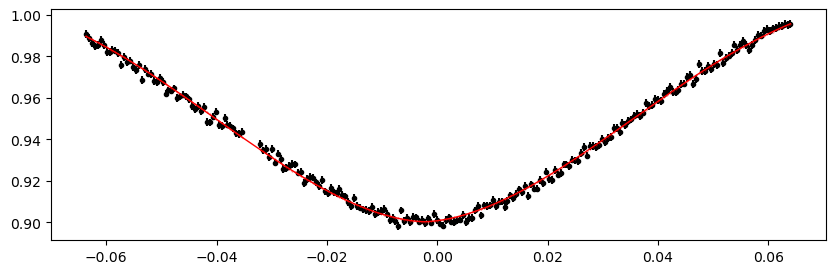

3090.1572889999998 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 345.32it/s]


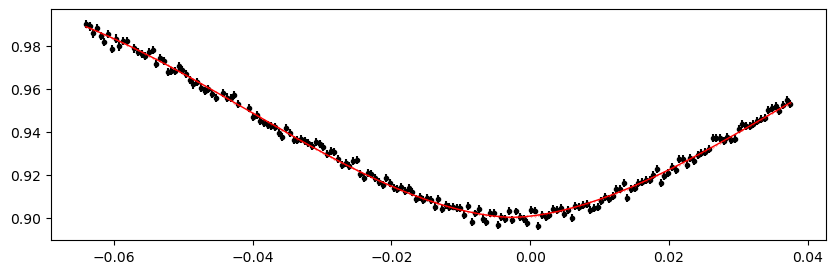

3092.7568145 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 327.35it/s]


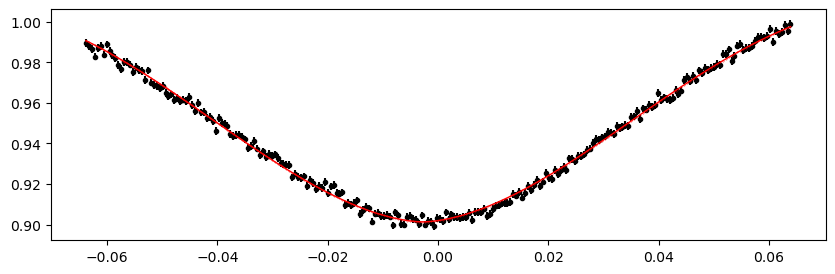

3095.3563400000003 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.96it/s]


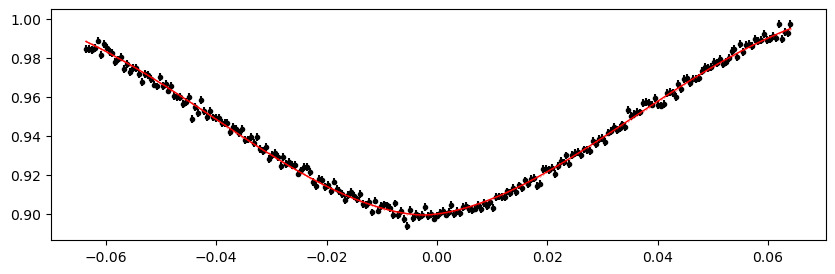

3097.9558655 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 325.35it/s]


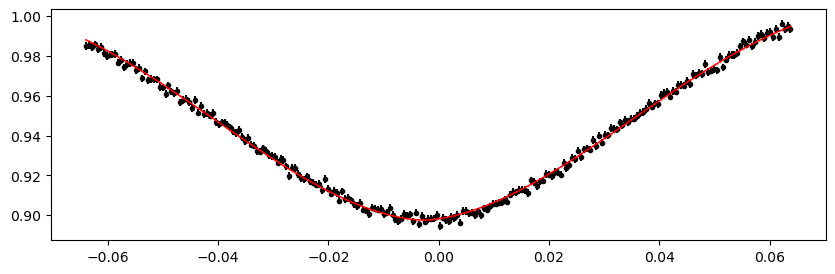

3100.555391 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 327.00it/s]


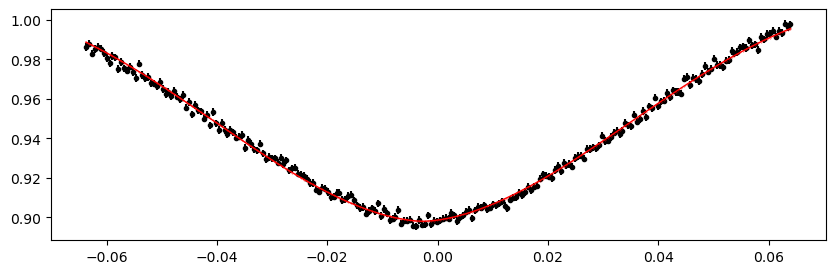

3103.1549165 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 325.44it/s]


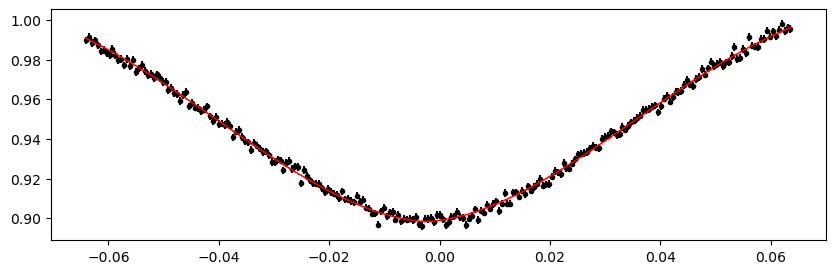

3105.7544420000004 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 324.33it/s]


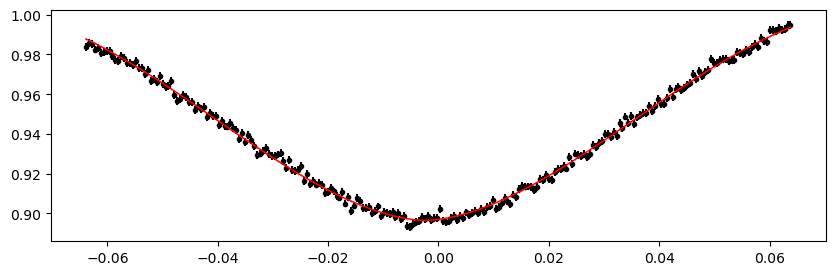

3113.5530185 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 324.56it/s]


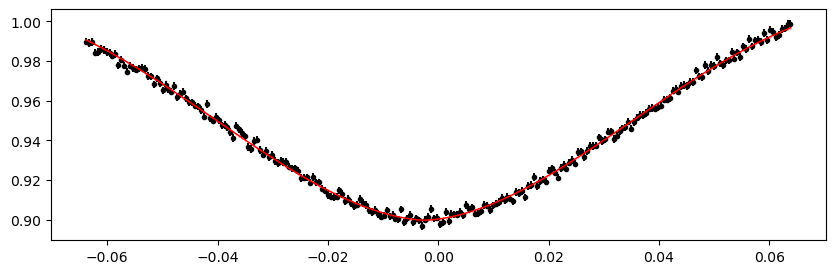

3116.152544 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.87it/s]


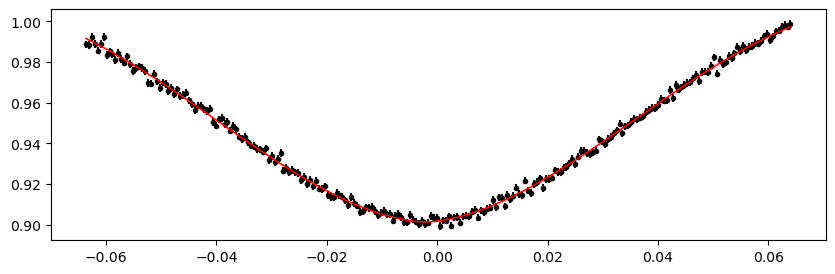

3118.7520695000003 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 330.51it/s]


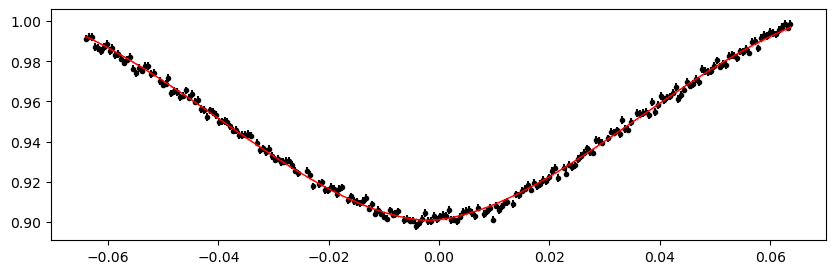

3121.351595 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 324.50it/s]


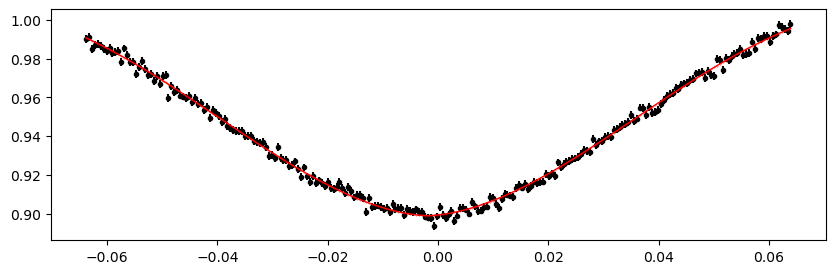

3126.550646 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 421.33it/s]


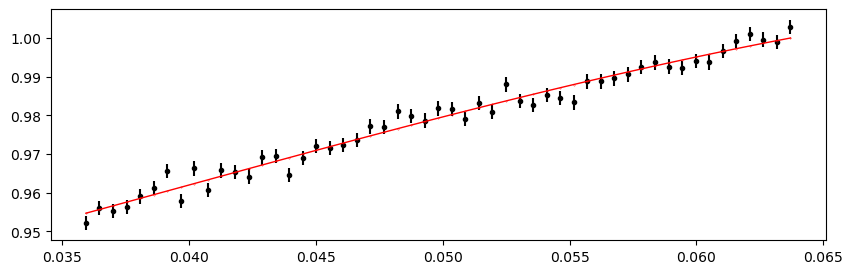

3129.1501715 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.37it/s]


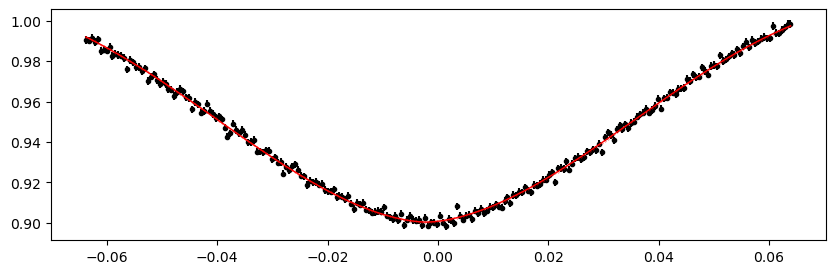

3131.749697 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 322.95it/s]


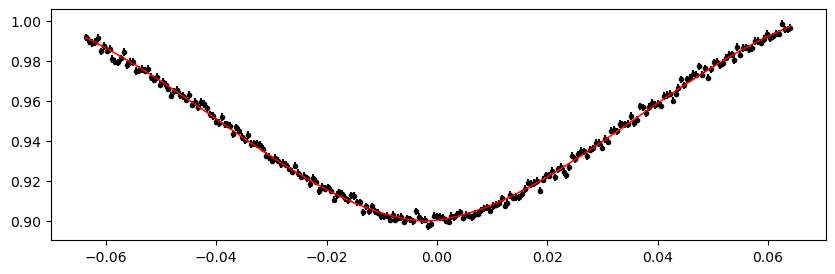

3134.3492225 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 322.05it/s]


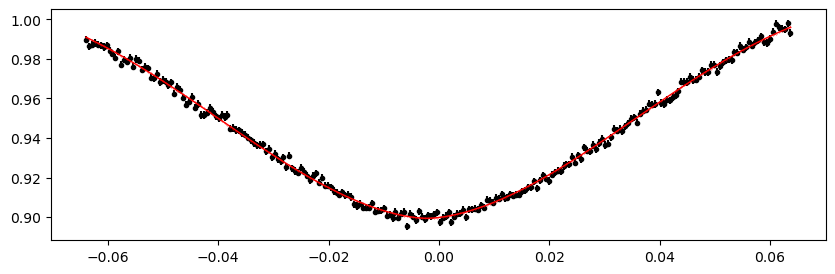

3142.1477990000003 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 301.91it/s]


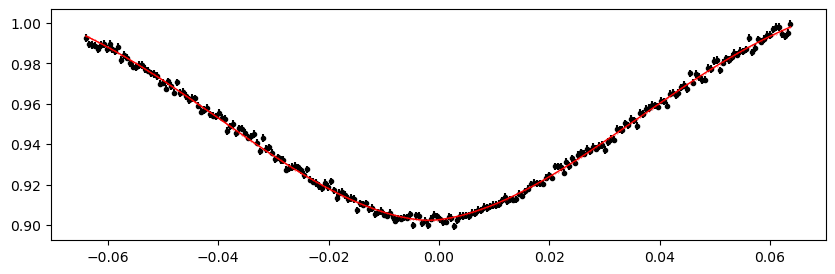

3144.7473245 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 298.92it/s]


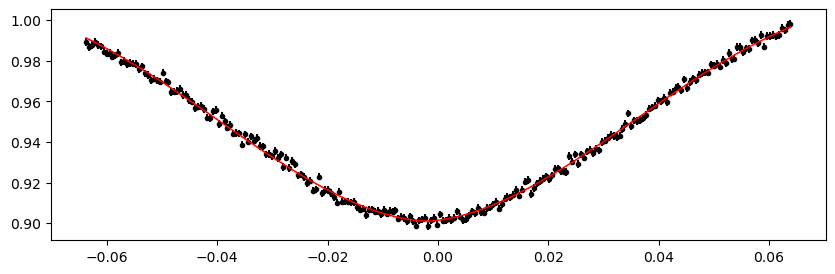

3147.34685 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 357.08it/s]


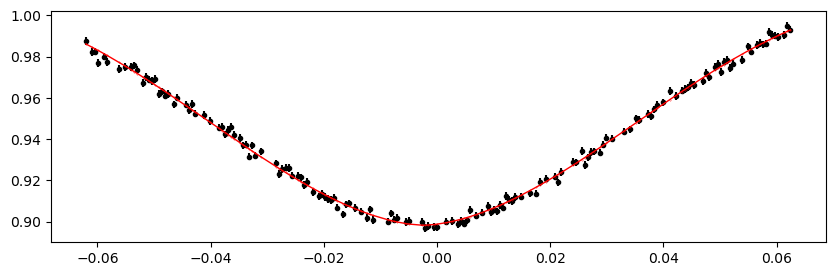

3149.9463754999997 1.0152580019795232 -0.11270855323064222 -0.2741334870537342


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.70it/s]


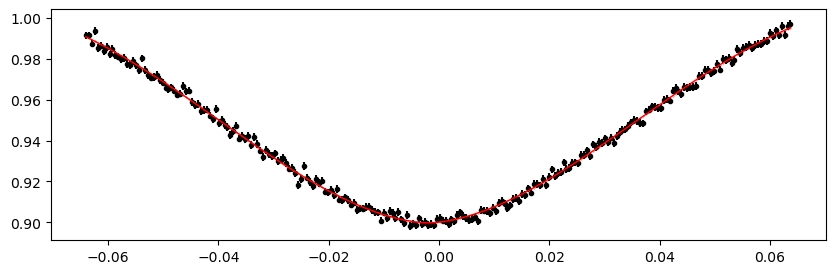

In [23]:
# ---

%matplotlib inline

if t0_secondary is not None:
    print("Fitting individual secondary eclipses...")
    etv_functions.fit_each_eclipse(data_secondary, n_transits, t0_secondary, period, mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, outfile_path_s,
                                   min_number_data=13,  # accomodate 1 sector of 30 min cadence data
                                  )
    !$NOTIFY_CMD "Individual secondary eclipses fit done"
else:
    print("No secondary eclipses defined. No-Op.")

## ETV O-C plot

Note: data points around BTJD 1630-1650, the only 30-minute cadence data sector (12), seems to unreliable.

Note: 6 data points in in_df_secondary filtered out (outliers, even among  unreliable 30 min cadence data).


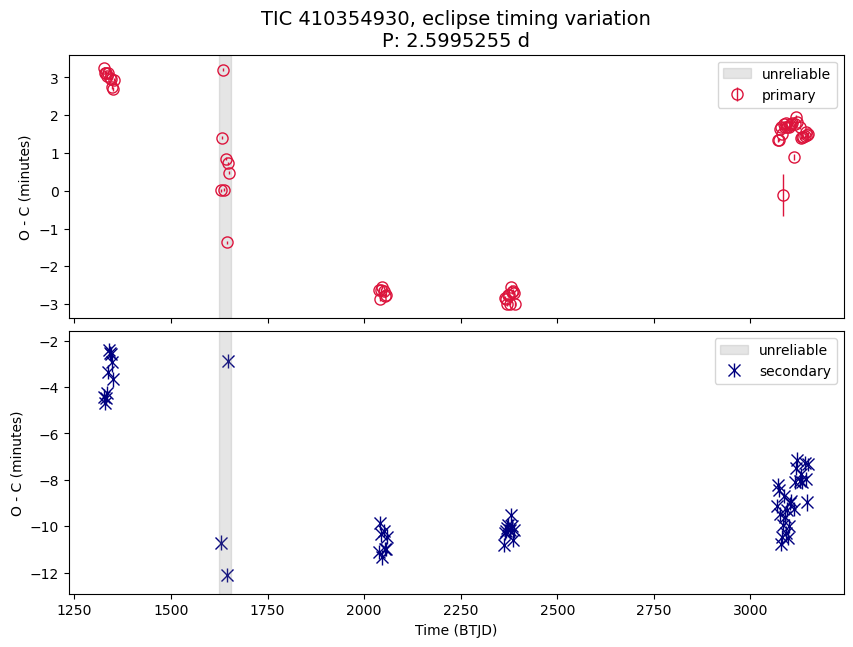

In [33]:
%matplotlib inline
# %matplotlib widget


title_suffix = "eclipse timing variation"

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
# num_rows = 1  # force to plot primary only
# figsize_y = 3.3

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60
in_df_primary_all = in_df_primary  # in case filtering is helpful

# in_df_primary = in_df_primary[in_df_primary.std_mins < 10]  # filter out outliers in error
# print(f"Note: {len(in_df_primary_all) - len(in_df_primary)} data points in df_primary filtered out due to huge O-C error.")

# axs[0].plot(in_df_primary['epoch'], in_df_primary['shift_mins'], 
#              lw = 1, color = 'crimson', )
# axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'], 
#              marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
axs[0].errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'], 
             lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")
axs[0].axvspan(1625, 1655, color="gray", alpha=0.2, label="unreliable")

# if False:
if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60    
    in_df_secondary_all = in_df_secondary  # in case filtering is helpful
    
    in_df_secondary = in_df_secondary[in_df_secondary.std_mins < 10]  # filter out outliers in error
    in_df_secondary = in_df_secondary[in_df_secondary.shift_mins > -14]  # outliers
    print(f"Note: {len(in_df_secondary_all) - len(in_df_secondary)} data points in in_df_secondary filtered out (outliers, even among  unreliable 30 min cadence data).")
    
    # axs[1].plot(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              lw = 1, color = 'navy', )
    # axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
    axs[1].errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'], 
                 lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
    axs[1].axvspan(1625, 1655, color="gray", alpha=0.2, label="unreliable")
else:
    in_df_secondary = None

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"TIC {ticid}, {title_suffix}\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.05)
# plt.ylim(-3, 8)
plt.show()

### Compare with O-C plot with ingress/egress

with ingress/egess included in the model (1.2X duration).

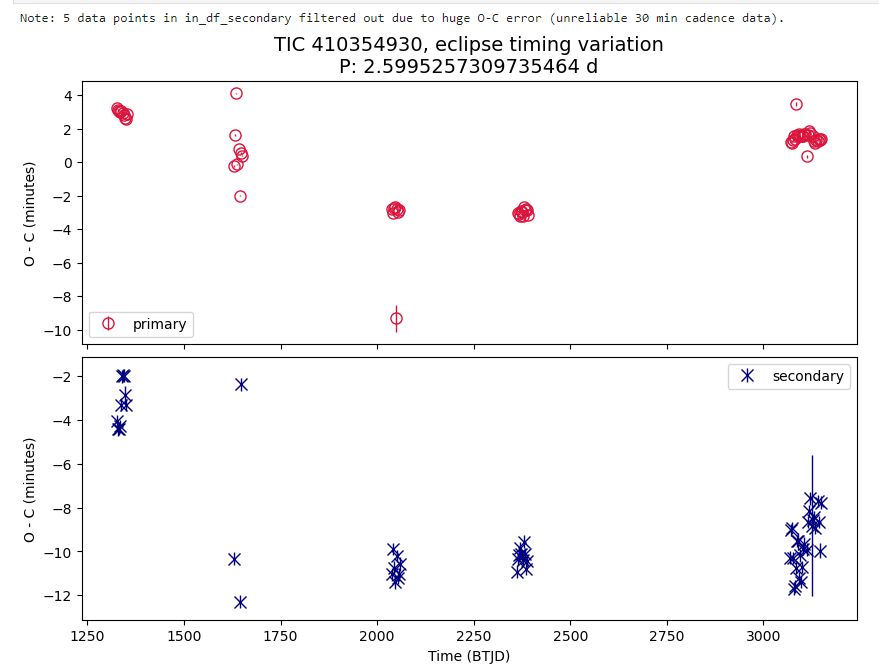

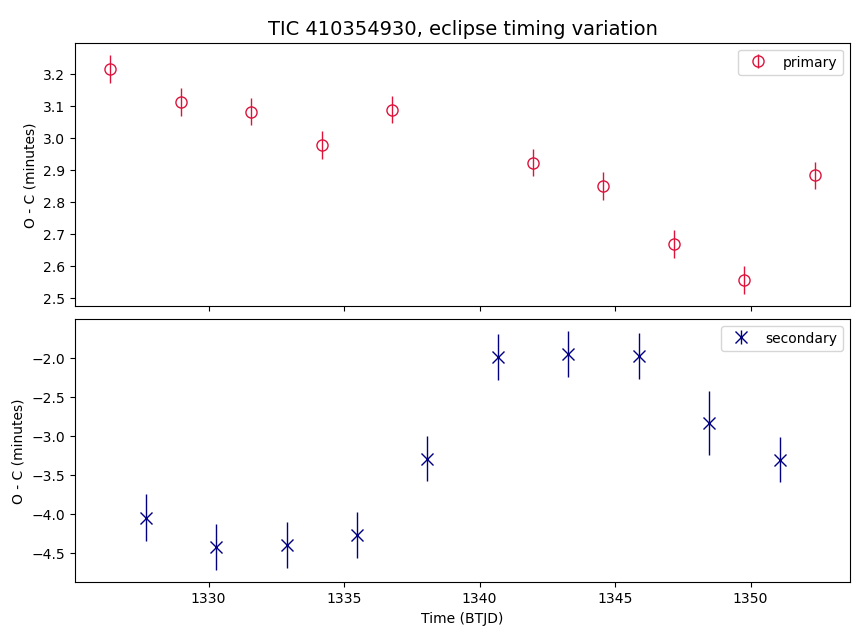

...

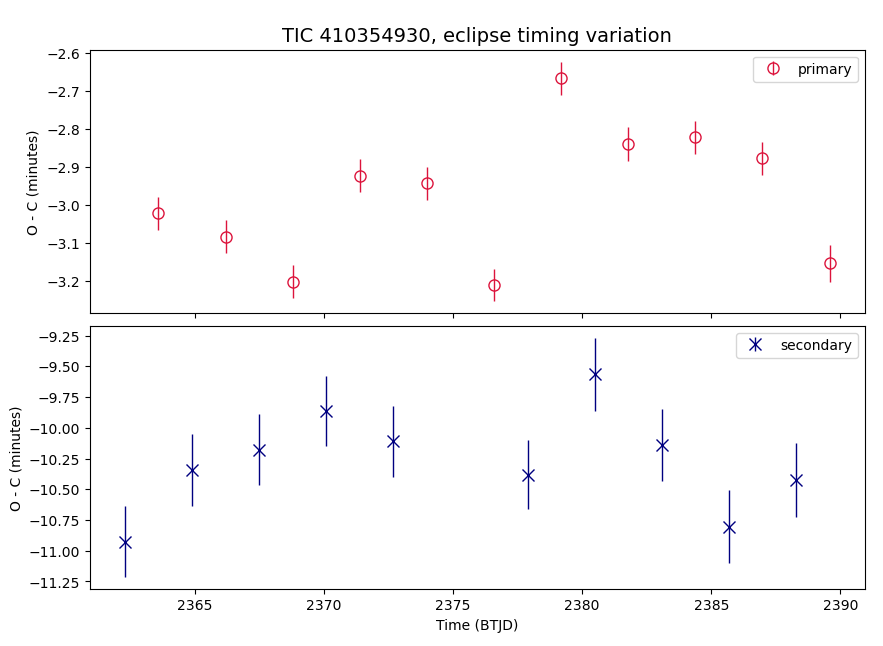

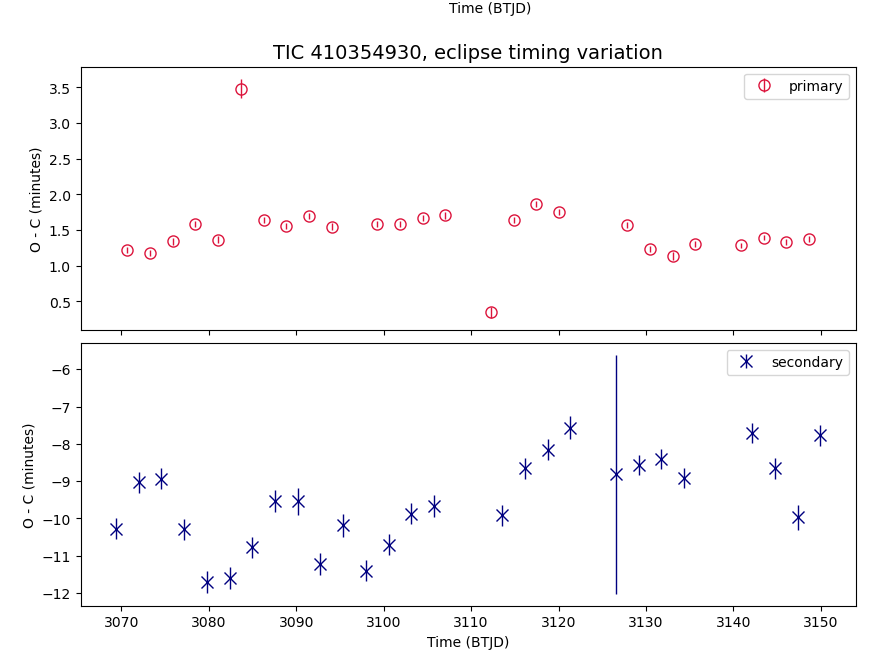


In [ ]:
# # to help to filter out valeus with huge error
# ax = in_df_primary_all.std_mins.hist(bins=100)
# ax.set_xscale("log")
# ax.set_yscale("log")
# plt.show()

# ax = in_df_secondary_all.std_mins.hist(bins=100)
# ax.set_xscale("log")
# ax.set_yscale("log")
# plt.show()

### O-C Plot, Zoom In

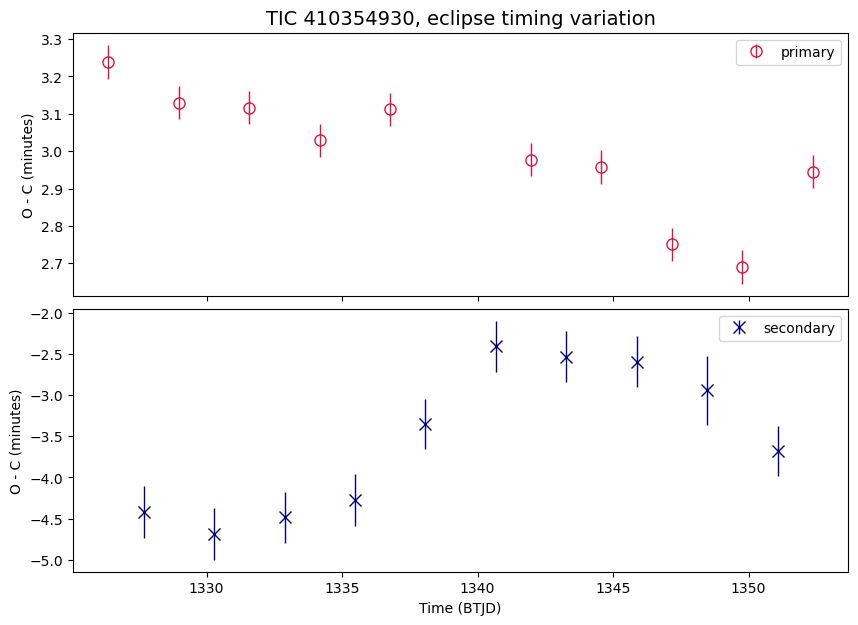

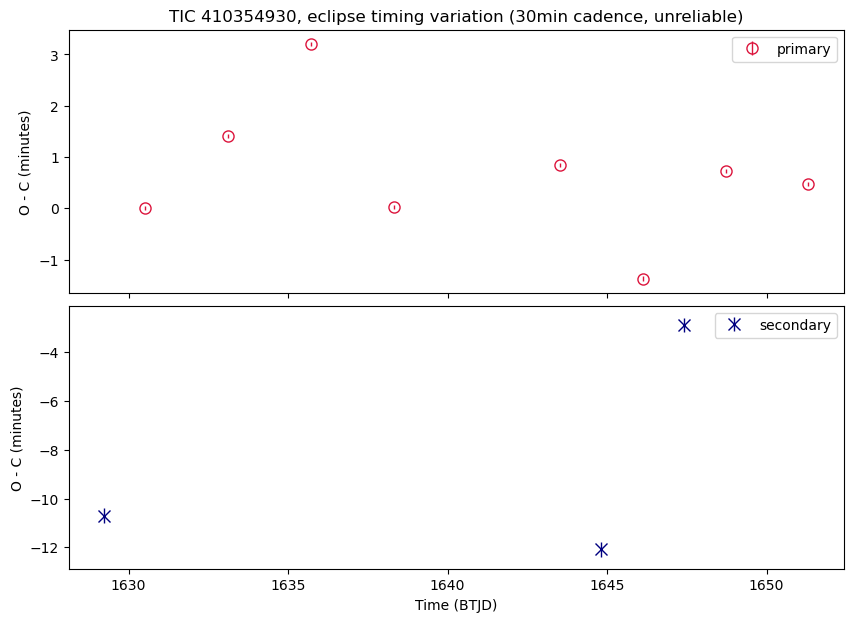

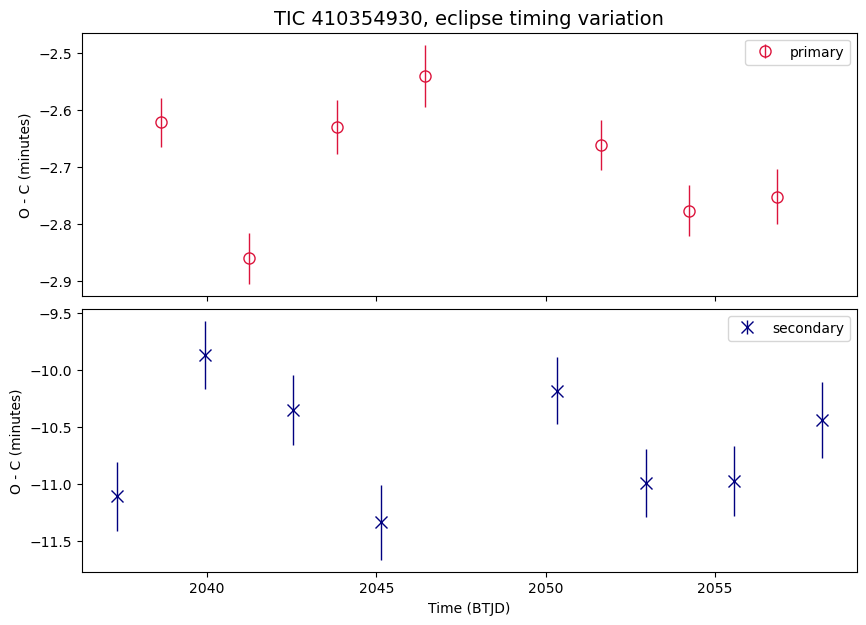

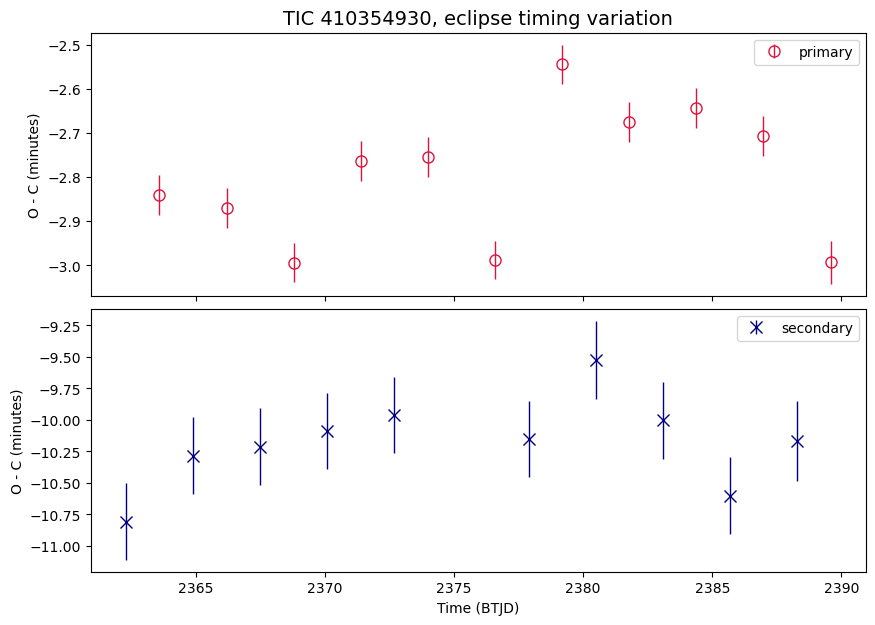

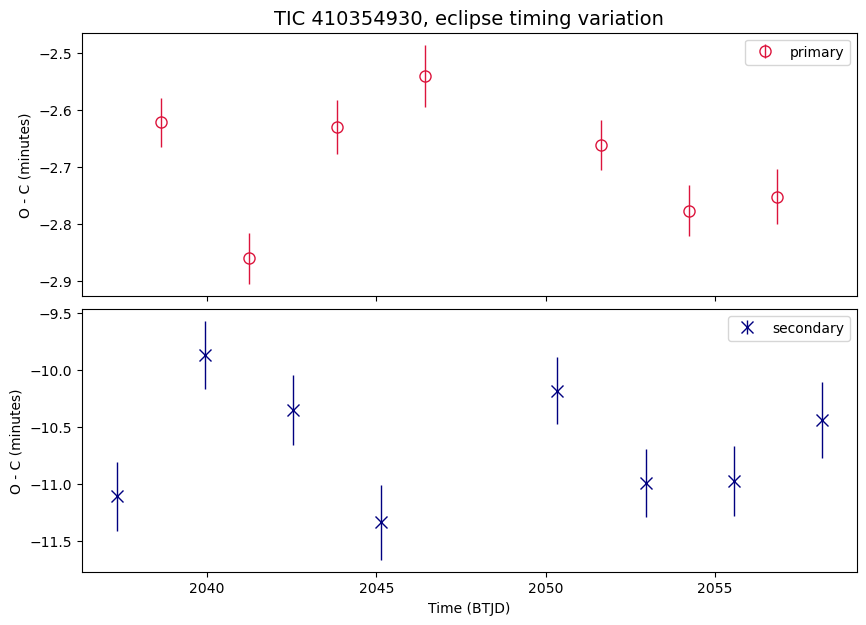

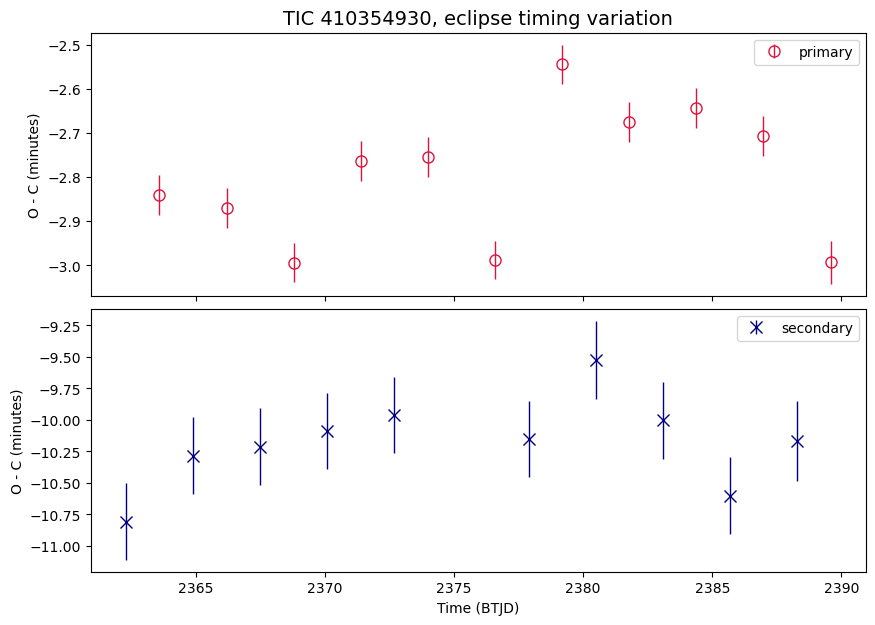

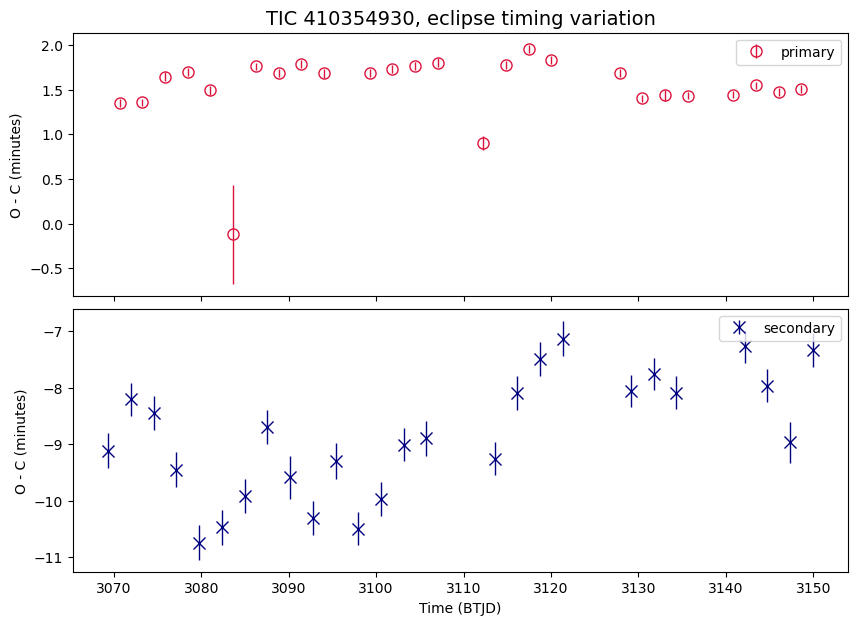

In [32]:
%matplotlib inline
# %matplotlib widget

zoom_ranges = [
    (1250, 1500),
    (1500, 1700),
    (2000, 2200),
    (2250, 2450),
    (2000, 2100),
    (2350, 2450),
    (3000, 3200),
]

def tweak_axs_list(axs_list):
    # axs_list[0][1].set_ylim(-20, 30);
    # axs_list[1][0].set_ylim(None, 0.5);
    # axs_list[1][1].set_ylim(-5.5, 2);

    ax = axs_list[1][0]
    ax.set_title(f"{ax.get_title()} (30min cadence, unreliable)")    
    pass


def plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges):
    axs_list = []
    for zoom_start, zoom_end in zoom_ranges:
        num_rows = 2 if t0_secondary is not None else 1
        figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
    
        fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
        if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
            axs = [axs]
        
        df_zoom = in_df_primary[(in_df_primary['epoch'] > zoom_start) & (in_df_primary['epoch'] < zoom_end)]
              
        # axs[0].scatter(df_zoom['epoch'], df_zoom['shift_mins'], 
        #                marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
        axs[0].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'], 
                        lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")
        
        if in_df_secondary is not None:
            df_zoom = in_df_secondary[(in_df_secondary['epoch'] > zoom_start) & (in_df_secondary['epoch'] < zoom_end)]
        
            # axs[1].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
            #                marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
            axs[1].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
                            lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
        
        for ax in axs:
            ax.set_ylabel("O - C (minutes)")
            ax.legend();
        
        axs[-1].set_xlabel("Time (BTJD)")
        axs[0].set_title(f"TIC {ticid}, {title_suffix}", fontsize=14)
        
        plt.subplots_adjust(hspace=0.05)
        axs_list.append(axs)
    return axs_list


axs_list = plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges)
tweak_axs_list(axs_list);

## make a periodogram 

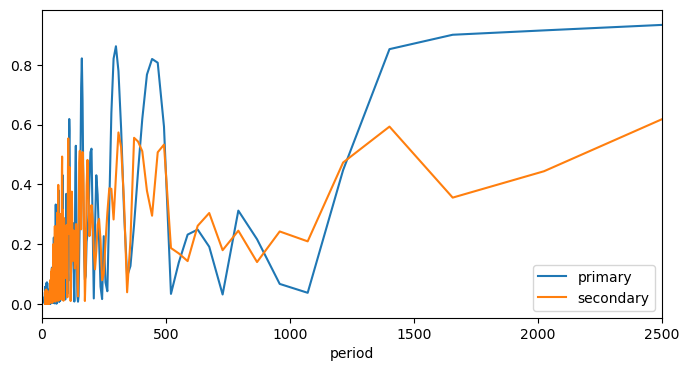

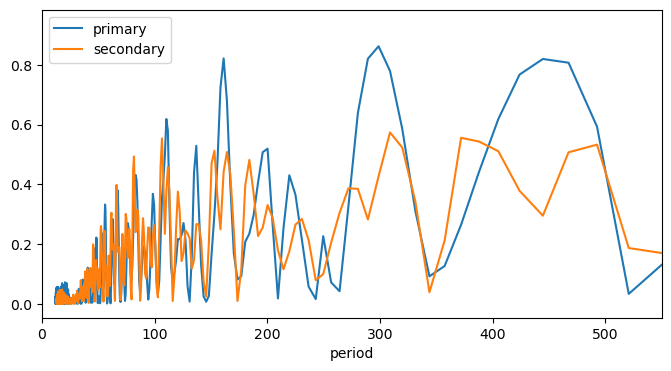

In [34]:
frequency, power = LombScargle(in_df_primary['epoch'], in_df_primary['shift_mins']).autopower()

fig, ax = plt.subplots(figsize=(8, 4))

plt.plot(1/frequency, power, label = 'primary')    

if t0_secondary is not None:
    frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
    plt.plot(1/frequency_s, power_s, label = 'secondary')    

plt.xlabel("period")

plt.legend()
plt.xlim(0, 2500)
plt.show()


if True:
    fig, ax = plt.subplots(figsize=(8, 4))
    
    plt.plot(1/frequency, power, label = 'primary')    
    
    if t0_secondary is not None:
        plt.plot(1/frequency_s, power_s, label = 'secondary')    
    
    plt.xlabel("period")
    
    plt.legend()
    plt.xlim(0, 550)
    plt.show()

## O-C plot, folded

- for periodic trend in O-C

In [36]:
def truncate_freq_power_to_period_range(freq, power, period_min, period_max):
    f, p = freq, power
    if period_min is not None:
        f, p = f[f < 1 / period_min], p[f < 1 / period_min]
    if period_max is not None:
        f, p = f[f > 1 / period_max], p[f >  1 / period_max]
    return f, p


def plot_oc_folded(period_min=None, period_max=None, period_min_s=None, period_max_s=None, period=None, period_s=None):

    if period is None:
        _f, _p = truncate_freq_power_to_period_range(frequency, power, period_min, period_max)
        period = 1 / _f[np.argmax(_p)]
    phase_oc = etv_functions.phase_data(in_df_primary.epoch, 0, period)

    fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y * 1.1), sharex=False)
    if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
        axs = [axs]
    
    axs[0].scatter(phase_oc, in_df_primary.shift_mins, marker = 'o', s=12**2, c=in_df_primary.epoch);
    axs[0].errorbar(phase_oc, in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'],
                    lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'None', label="primary")
    axs[0].set_title(f"TIC {ticid}, {title_suffix}\nfolded with P={period:.4f} d", fontsize=14)

    if in_df_secondary is not None:
        if period_s is None:
            _f, _p = truncate_freq_power_to_period_range(frequency_s, power_s, period_min_s, period_max_s)
            period_s= 1 / _f[np.argmax(_p)]
        phase_oc_s = etv_functions.phase_data(in_df_secondary.epoch, 0, period_s)
        axs[1].scatter(phase_oc_s, in_df_secondary.shift_mins, marker = 'o',  s=12**2, c=in_df_secondary.epoch);
        axs[1].errorbar(phase_oc_s, in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'],
                        lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color='None', ecolor='navy', markeredgecolor = 'None', label="secondary" );
        axs[1].set_title(f"TIC {ticid}, {title_suffix}\nfolded with P={period_s:.4f} d", fontsize=14)

    for ax in axs:
        ax.set_ylabel("O - C (minutes)")
        ax.set_xlabel("Phase (Normalized)")
        ax.legend();
    plt.subplots_adjust(hspace=0.4)
    return axs

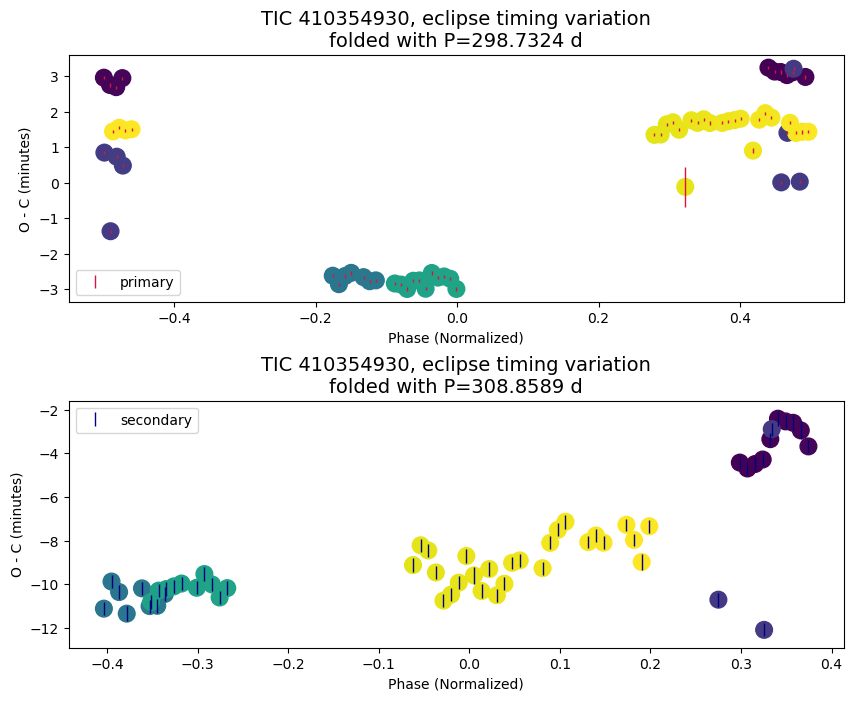

In [37]:
%matplotlib inline
# %matplotlib widget

if True:  # plot O-C periodic trend by folding with a period (from LS Periodogram by default)
    def tweak_axs(axs):
        pass

    axs = plot_oc_folded(
        period_min=None, period_max=1000,
        period_min_s=None, period_max_s=1000
    )
    tweak_axs(axs)

## Results Summary

In [39]:
# FILL-IN the ETV results / comments
has_etv = "Y"
comments = "O-C suggests long-term (1800+ days) non-linear trend (amplitude > 6 min for primary, > 14 min for secondary), no clear O-C period. The trend of primary seems to be opposite of that of secondary in short time scale. EB : SB Period ~= 1.7 : 1. [D*0.8]"

# Eclipse depth from the model
depth_pct_p = round(-mean_alpha1 * 100, 2)
if t0_secondary is not None:
    depth_pct_s = round(-mean_alpha1_s * 100, 2)
else:
    depth_pct_s = None

summary = {
    "tic": ticid,
    "has_etv": has_etv,
    "comments": comments,
    "period": period,  # the period used in ETV analysis
    "depth_pct_p": depth_pct_p,
    "depth_pct_s": depth_pct_s,
    "epoch_p": t0_primary,
    "epoch_s": t0_secondary,
    "num_sectors": len(sr),
    "time_span": round(time[-1] - time[0], 2),
    "time_start": round(time[0], 2),
    "time_end": round(time[-1], 2),
}

summary = pd.DataFrame.from_dict(summary, orient="index")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 999, 'display.max_columns', 99):
    display(summary);

# Single line to be added to a CSV
print("")
print(summary.transpose().to_csv(
    index=False,
    header=True, 
))

0
tic                                                                                                                                                                                                                               410354930
has_etv                                                                                                                                                                                                                                   Y
comments     O-C suggests long-term (1800+ days) non-linear trend (amplitude > 6 min for primary, > 14 min for secondary), no clear O-C period. The trend of primary seems to be opposite of that of secondary. EB : SB Period ~= 1.7 : 1. 
period                                                                                                                                                                                                                             2.599525
depth_pct_p                                                                                                                                                                                                                           64.84
depth_pct_s                                                                                                                                                                                                                           11.27
epoch_p                                                                                                                                                                                                                            1326.373
epoch_s                                                                                                                                                                                                                            1327.679
num_sectors                                                                                                                                                                                                                               7
time_span                                                                                                                                                                                                                            1829.1
time_start                                                                                                                                                                                                                           1325.3
time_end                                                                                                                                                                                                                             3154.4


tic,has_etv,comments,period,depth_pct_p,depth_pct_s,epoch_p,epoch_s,num_sectors,time_span,time_start,time_end
410354930,Y,"O-C suggests long-term (1800+ days) non-linear trend (amplitude > 6 min for primary, > 14 min for secondary), no clear O-C period. The trend of primary seems to be opposite of that of secondary. EB : SB Period ~= 1.7 : 1. ",2.5995255,64.84,11.27,1326.373,1327.679,7,1829.1,1325.3,3154.4

